# Machine Learning and Time Series Forecasting

## Import Fundamental Libraries

In [158]:
#import fundamental libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import common model validation tools
import math 
from statistics import mean
from sklearn.metrics import mean_squared_error, mean_absolute_error


### Engineer the necessary time features

In [159]:
ecom_df = pd.read_csv('../Data/Brazilian E-Commerce Public Dataset by Olist/ecom.csv')

ecom_df['Year'] = ecom_df['Year'].astype(str)
ecom_df['Month'] = ecom_df['Month'].astype(str)

#Change the column name
ecom_df = ecom_df.rename(columns={'product_category_name_english':'Product'})

ecom_df['order_purchase_date'] = pd.to_datetime(ecom_df['order_purchase_date'])
ecom_df['Week_Number'] = ecom_df['order_purchase_date'].dt.week

# Extract the week and year into new columns
ecom_df["Week_Year"] = ecom_df["order_purchase_date"].dt.strftime('%G-%V')

# Convert the 'Week_Year' column to datetime format
ecom_df['week_starting_date'] = pd.to_datetime(ecom_df['Week_Year'] + '-1', format='%Y-%W-%w')
# Extract the date part (yyyy-mm-dd) from the datetime
ecom_df['week_starting_date'] = ecom_df['week_starting_date'].dt.strftime('%Y-%m-%d')


ecom_df['Revenue'] = ecom_df['Product_Order_Value']+ecom_df['freight_value']
ecom_df

C:\Users\Yomal Sandaruwan\AppData\Local\Temp\ipykernel_2832\2406026423.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  ecom_df['Week_Number'] = ecom_df['order_purchase_date'].dt.week


,ID,neg,neu,pos,compound,order_purchase_date,Product,review_comment_message,payment_type,customer_state,...,product_description_lenght,product_photos_qty,Month_Year,Year,Month,Product_Order_Value,Week_Number,Week_Year,week_starting_date,Revenue
0,1,0.000,0.738,0.262,0.5994,2017-01-05,auto,"I loved the product, matches the images, the d...",boleto,PR,...,1367.0,1.0,Jan-2017,2017,1,10.9,1,2017-01,2017-01-02,19.62
1,2,0.000,0.374,0.626,0.9544,2017-01-05,auto,"Very good seller, arrived well before the dead...",boleto,PR,...,1367.0,1.0,Jan-2017,2017,1,10.9,1,2017-01,2017-01-02,19.62
2,3,0.000,0.631,0.369,0.6249,2017-01-05,baby,"Fast delivery, product with quality and great ...",boleto,PR,...,1183.0,1.0,Jan-2017,2017,1,9.9,1,2017-01,2017-01-02,18.62
3,4,0.000,0.556,0.444,0.8402,2017-01-05,baby,The product was of great quality and the deliv...,boleto,PR,...,1890.0,1.0,Jan-2017,2017,1,11.9,1,2017-01,2017-01-02,20.62
4,23,0.000,0.417,0.583,0.4201,2017-01-05,toys,I highly recommend Targaryen,boleto,PR,...,2136.0,1.0,Jan-2017,2017,1,8.9,1,2017-01,2017-01-02,17.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32213,40760,0.000,0.000,1.000,0.3612,2018-08-29,health_beauty,I recommend,voucher,MG,...,394.0,1.0,Aug-2018,2018,8,45.9,35,2018-35,2018-08-27,61.29
32214,40761,0.000,1.000,0.000,0.0000,2018-08-29,health_beauty,The product arrived faster than expected,credit_card,SP,...,2411.0,1.0,Aug-2018,2018,8,65.0,35,2018-35,2018-08-27,74.21
32215,40762,0.000,1.000,0.000,0.0000,2018-08-29,sports_leisure,"Fast delivery, even before the deadline.",credit_card,SP,...,73.0,3.0,Aug-2018,2018,8,6.9,35,2018-35,2018-08-27,14.29
32216,40763,0.076,0.655,0.269,0.6808,2018-08-29,toys,I found the product very small and where is th...,credit_card,SP,...,711.0,2.0,Aug-2018,2018,8,63.9,35,2018-35,2018-08-27,73.10


In [160]:
ecom_df.columns

Index(['ID', 'neg', 'neu', 'pos', 'compound', 'order_purchase_date', 'Product',
       'review_comment_message', 'payment_type', 'customer_state', 'sales_qty',
       'review_score', 'price', 'freight_value', 'payment_value',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'Month_Year', 'Year', 'Month',
       'Product_Order_Value', 'Week_Number', 'Week_Year', 'week_starting_date',
       'Revenue'],
      dtype='object')

### Data Overview

#### Weekly View of Sales Revenue Data

In [161]:
#Weekly Sales table
Weekly_revenue_df = ecom_df.groupby(['Year','Month','Month_Year','Week_Number','Week_Year','Product','week_starting_date']).agg({'neg':'sum','neu':'sum','pos':'sum','compound':'sum','sales_qty':'sum','review_score':'sum','price':'sum','freight_value':'sum','product_name_lenght':'mean','product_description_lenght':'mean','product_photos_qty':'mean','Revenue':'sum'})
Weekly_revenue_df = Weekly_revenue_df.sort_values(by=['week_starting_date'],ascending=True)
Weekly_revenue_df = Weekly_revenue_df.reset_index(drop=False)
Weekly_revenue_df

,Year,Month,Month_Year,Week_Number,Week_Year,Product,week_starting_date,neg,neu,pos,compound,sales_qty,review_score,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,Revenue
0,2017,1,Jan-2017,1,2017-01,auto,2017-01-02,0.000,1.112,0.888,1.5538,2,10.0,21.80,17.44,52.0,1367.00,1.0,39.24
1,2017,1,Jan-2017,1,2017-01,baby,2017-01-02,0.000,1.187,0.813,1.4651,2,10.0,21.80,17.44,41.0,1536.50,1.0,39.24
2,2017,1,Jan-2017,1,2017-01,bed_bath_table,2017-01-02,0.000,0.654,0.346,0.5719,1,3.0,68.90,15.69,56.0,501.00,3.0,84.59
3,2017,1,Jan-2017,1,2017-01,cool_stuff,2017-01-02,0.000,1.000,0.000,0.0000,2,1.0,798.00,48.52,44.0,422.00,4.0,1644.52
4,2017,1,Jan-2017,1,2017-01,furniture_decor,2017-01-02,0.123,1.877,0.000,-0.1027,3,2.0,294.70,54.91,58.5,343.75,3.0,609.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521,2018,8,Aug-2018,35,2018-35,baby,2018-08-27,0.000,1.000,0.000,0.0000,1,1.0,49.99,8.86,33.0,55.00,2.0,58.85
1522,2018,8,Aug-2018,35,2018-35,auto,2018-08-27,0.140,1.183,0.677,0.4118,2,8.0,197.99,23.94,57.0,404.50,2.5,221.93
1523,2018,8,Aug-2018,35,2018-35,toys,2018-08-27,0.284,1.447,0.269,0.2856,2,4.0,89.89,17.54,42.0,452.50,1.5,107.43
1524,2018,8,Aug-2018,35,2018-35,garden_tools,2018-08-27,0.000,1.000,0.000,0.0000,2,1.0,84.00,25.60,55.0,271.00,1.0,193.60


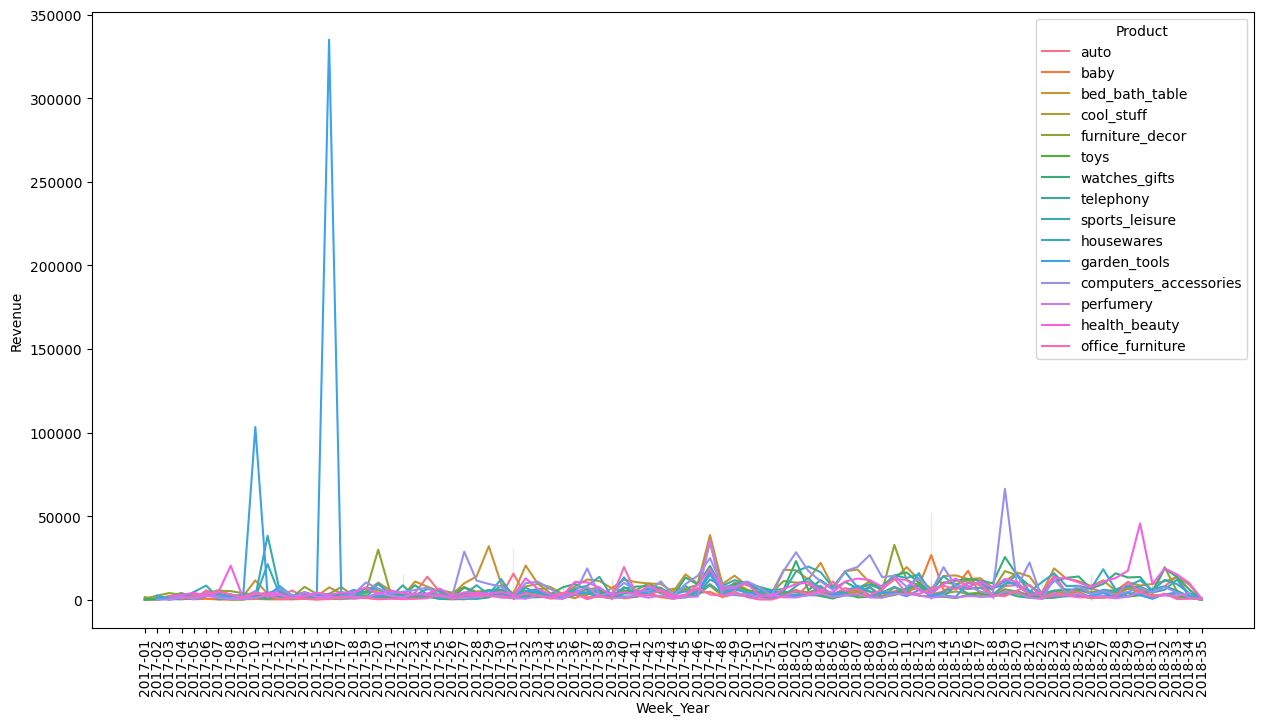

In [162]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(data = Weekly_revenue_df, x='Week_Year', y='Revenue',hue='Product')
plt.xticks(rotation = 90)
sns.move_legend(ax,'upper right')
plt.show()

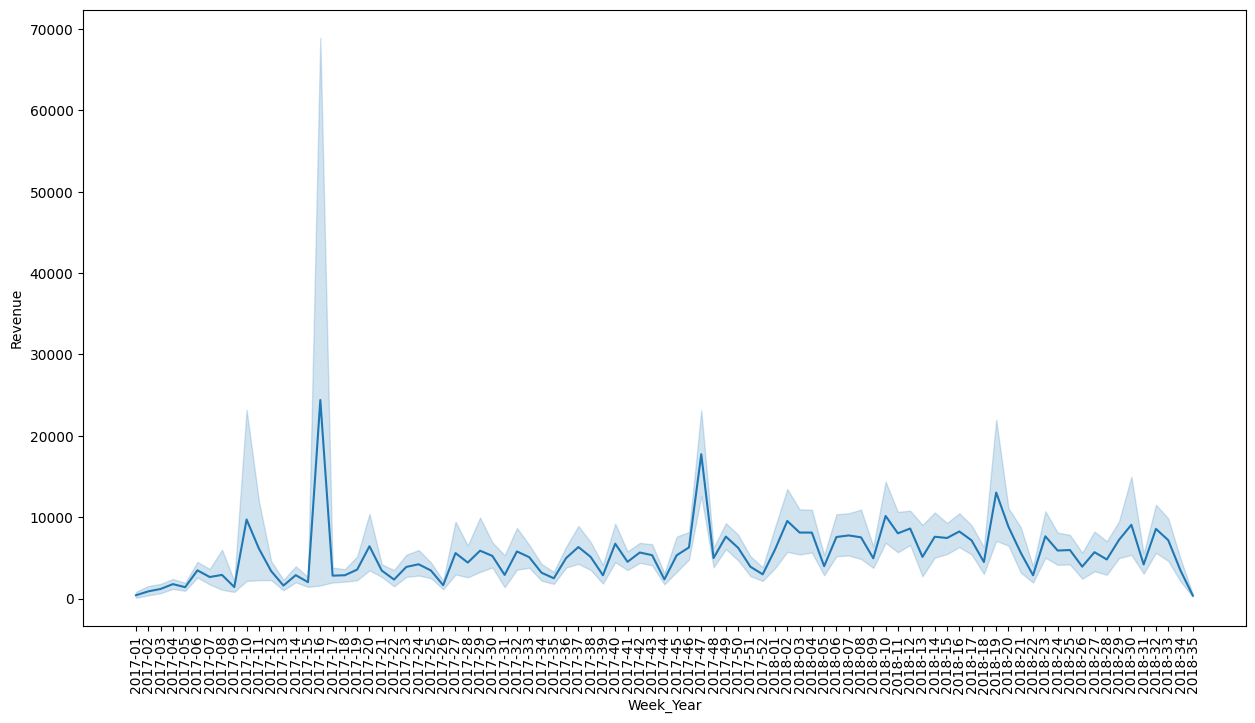

In [163]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(data = Weekly_revenue_df, x='Week_Year', y='Revenue')
plt.xticks(rotation = 90)
plt.show()

### Outliar Handling

Identify the outliers using box plot

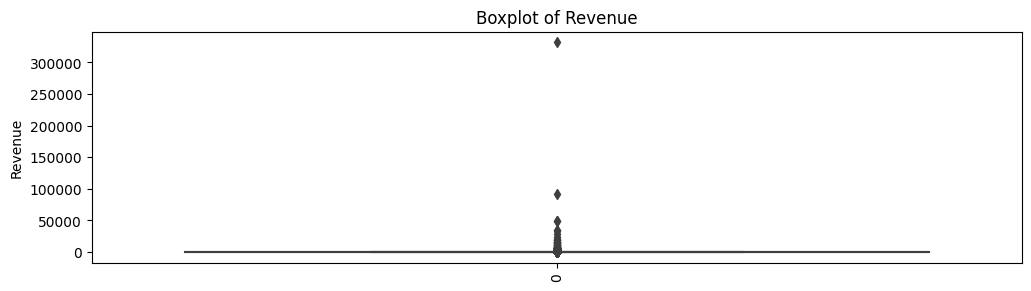

In [164]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=ecom_df['Revenue'])
plt.title(f'Boxplot of Revenue')
plt.xticks(rotation = 90)
plt.ylabel('Revenue')
plt.show()

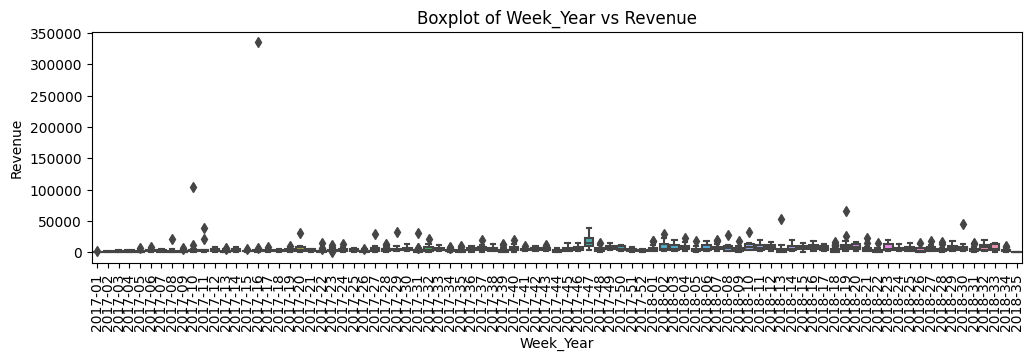

In [165]:
# Create separate box plots for each categorical column
plt.figure(figsize=(12, 3))
sns.boxplot(data=Weekly_revenue_df, x='Week_Year', y='Revenue')
plt.title(f'Boxplot of Week_Year vs Revenue')
plt.xlabel('Week_Year')
plt.xticks(rotation = 90)
plt.ylabel('Revenue')
plt.show()

Identify the lower bound and the upper bound
- The lower bound of the revenue column is -159.27 and the upper bound of the revenue column is 432.13

In [166]:
import pandas as pd
import numpy as np

# Assuming 'revenue' is the column in your DataFrame
Q1 = ecom_df['Revenue'].quantile(0.25)
Q3 = ecom_df['Revenue'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = (ecom_df['Revenue'] < lower_bound) | (ecom_df['Revenue'] > upper_bound)

print("Q1",Q1)
print("IQR",IQR)
print(lower_bound)
print(upper_bound)
print(outliers.sum())

Q1 68.13
IQR 145.60000000000002
-150.27000000000004
432.13000000000005
3068


Remove the outliers in revenue column and recreate the data frame (IQR)

In [167]:
# Create a new DataFrame without rows containing outliers
ecom_no_outliers = ecom_df[~outliers].copy()
ecom_no_outliers.shape

(29150, 26)

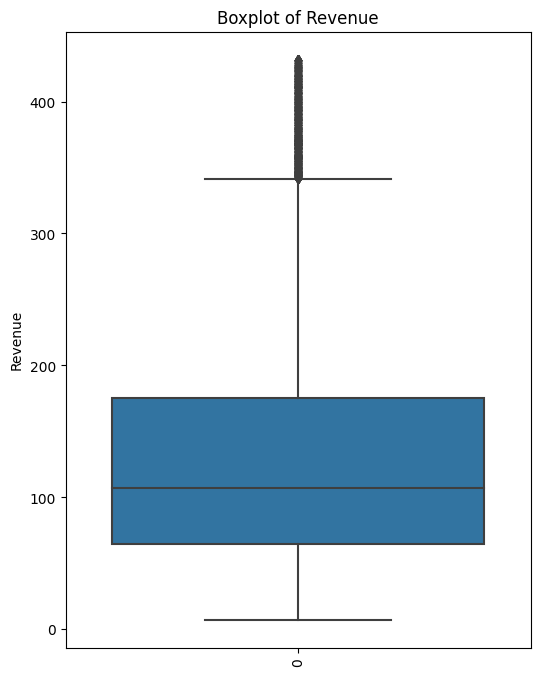

In [168]:
plt.figure(figsize=(6, 8))
sns.boxplot(data=ecom_no_outliers['Revenue'])
plt.title(f'Boxplot of Revenue')
plt.xticks(rotation = 90)
plt.ylabel('Revenue')
plt.show()

Regroup the data set after handling outliers

In [169]:
#Weekly Sales table
Weekly_revenue_df = ecom_no_outliers.groupby(['Year','Month','Month_Year','Week_Number','Week_Year','Product','week_starting_date']).agg({'neg':'sum','neu':'sum','pos':'sum','compound':'sum','sales_qty':'sum','review_score':'sum','price':'sum','freight_value':'sum','product_name_lenght':'mean','product_description_lenght':'mean','product_photos_qty':'mean','Revenue':'sum'})
Weekly_revenue_df = Weekly_revenue_df.sort_values(by=['week_starting_date'],ascending=True)
Weekly_revenue_df = Weekly_revenue_df.reset_index(drop=False)
Weekly_revenue_df

,Year,Month,Month_Year,Week_Number,Week_Year,Product,week_starting_date,neg,neu,pos,compound,sales_qty,review_score,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,Revenue
0,2017,1,Jan-2017,1,2017-01,auto,2017-01-02,0.000,1.112,0.888,1.5538,2,10.0,21.80,17.44,52.000000,1367.000000,1.000000,39.24
1,2017,1,Jan-2017,1,2017-01,baby,2017-01-02,0.000,1.187,0.813,1.4651,2,10.0,21.80,17.44,41.000000,1536.500000,1.000000,39.24
2,2017,1,Jan-2017,1,2017-01,bed_bath_table,2017-01-02,0.000,0.654,0.346,0.5719,1,3.0,68.90,15.69,56.000000,501.000000,3.000000,84.59
3,2017,1,Jan-2017,1,2017-01,furniture_decor,2017-01-02,0.000,1.000,0.000,0.0000,1,1.0,34.90,12.93,60.000000,448.000000,5.000000,47.83
4,2017,1,Jan-2017,1,2017-01,toys,2017-01-02,0.123,1.822,1.055,1.5764,3,14.0,203.79,40.06,49.666667,1199.666667,1.333333,243.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,2018,8,Aug-2018,35,2018-35,baby,2018-08-27,0.000,1.000,0.000,0.0000,1,1.0,49.99,8.86,33.000000,55.000000,2.000000,58.85
1508,2018,8,Aug-2018,35,2018-35,auto,2018-08-27,0.140,1.183,0.677,0.4118,2,8.0,197.99,23.94,57.000000,404.500000,2.500000,221.93
1509,2018,8,Aug-2018,35,2018-35,toys,2018-08-27,0.284,1.447,0.269,0.2856,2,4.0,89.89,17.54,42.000000,452.500000,1.500000,107.43
1510,2018,8,Aug-2018,35,2018-35,cool_stuff,2018-08-27,0.000,1.000,0.000,0.0000,1,5.0,119.99,9.00,57.000000,949.000000,2.000000,128.99


In [170]:
# Select the categorical columns
categorical_cols = [ 'Week_Year','Product']

Check the Outliers of the Data Frame in Weekly Level and Product Catergory Level

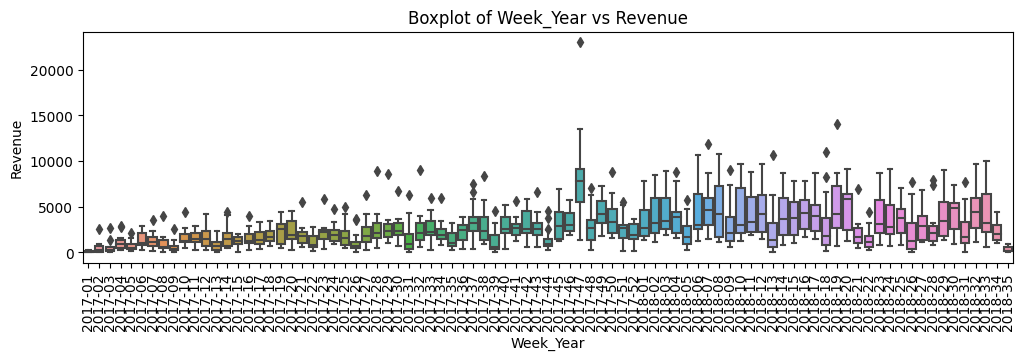

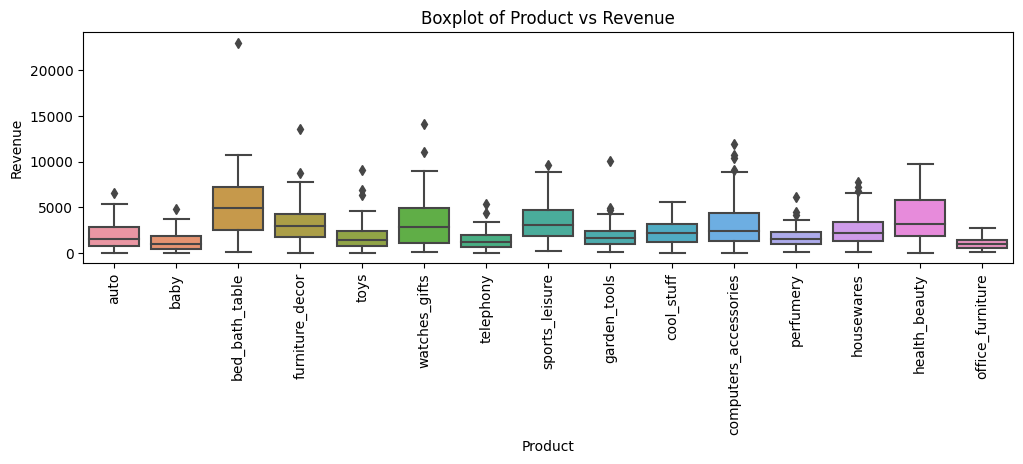

In [171]:
# Create separate box plots for each categorical column
for col in categorical_cols:
    plt.figure(figsize=(12, 3))
    sns.boxplot(data=Weekly_revenue_df, x=col, y='Revenue')
    plt.title(f'Boxplot of {col} vs Revenue')
    plt.xlabel(col)
    plt.xticks(rotation = 90)
    plt.ylabel('Revenue')
    plt.show()

Remove the Outliers using IQR Methods

In [172]:
# Dictionary to store the count of removed outliers for each category
removed_outliers_count = {}

# Loop through each categorical column
for col in categorical_cols:
    # Get the unique values in the column
    unique_values = Weekly_revenue_df[col].unique()
    
    # Iterate through each unique value
    for value in unique_values:
        # Calculate the IQR for the current category and value
        Q1 = Weekly_revenue_df[(Weekly_revenue_df[col] == value)]['Revenue'].quantile(0.25)
        Q3 = Weekly_revenue_df[(Weekly_revenue_df[col] == value)]['Revenue'].quantile(0.75)
        IQR = Q3 - Q1

        # Define the upper and lower bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify and count the outlier rows for the current category and value
        outliers = Weekly_revenue_df[(Weekly_revenue_df[col] == value) & ((Weekly_revenue_df['Revenue'] < lower_bound) | (Weekly_revenue_df['Revenue'] > upper_bound))]
        removed_outliers_count[(col, value)] = outliers.shape[0]

        # Remove the outlier rows for the current category and value
        Weekly_revenue_df = Weekly_revenue_df[~((Weekly_revenue_df[col] == value) & ((Weekly_revenue_df['Revenue'] < lower_bound) | (Weekly_revenue_df['Revenue'] > upper_bound)))]

# # Display the number of removed outlier rows for each category and value
# for (col, value), count in removed_outliers_count.items():
#     print(f"Removed {count} outliers in {col} category for value {value}.")

# Display the final cleaned data frame size
print("Final cleaned data frame size:", Weekly_revenue_df.shape)
Weekly_revenue_df=Weekly_revenue_df


Final cleaned data frame size: (1438, 19)


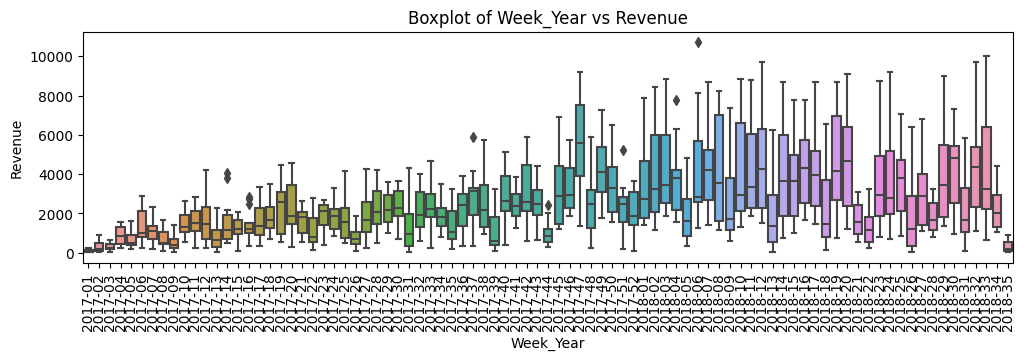

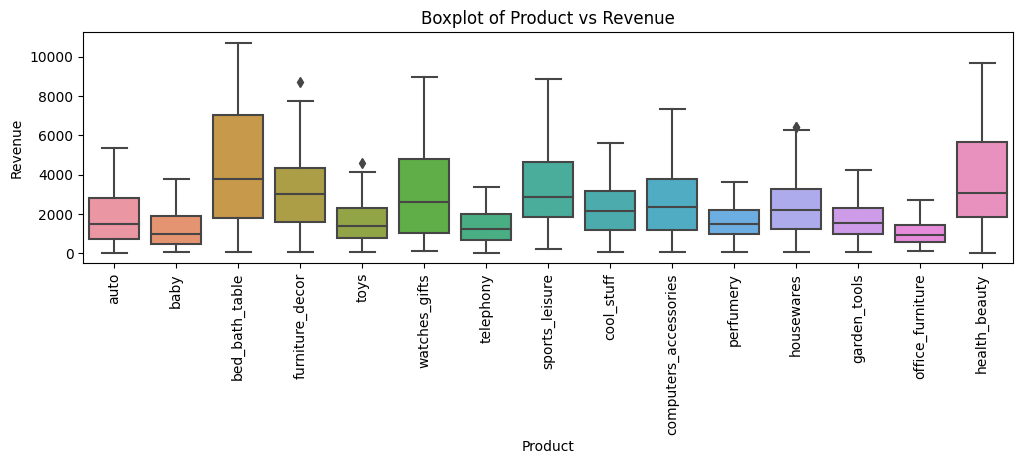

In [173]:
# Create separate box plots for each categorical column
for col in categorical_cols:
    plt.figure(figsize=(12, 3))
    sns.boxplot(data=Weekly_revenue_df, x=col, y='Revenue')
    plt.title(f'Boxplot of {col} vs Revenue')
    plt.xlabel(col)
    plt.xticks(rotation = 90)
    plt.ylabel('Revenue')
    plt.show()

Weekly Revenue over time after handling the outliers (Product Catergory Level)

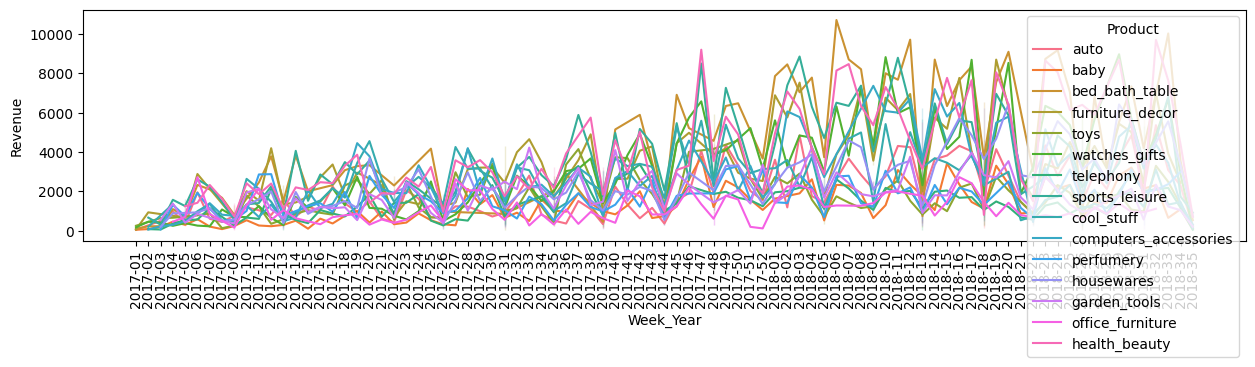

In [174]:
plt.figure(figsize=(15,3))
ax = sns.lineplot(data = Weekly_revenue_df, x='Week_Year', y='Revenue',hue='Product')
plt.xticks(rotation = 90)
sns.move_legend(ax,'upper right')
plt.show()

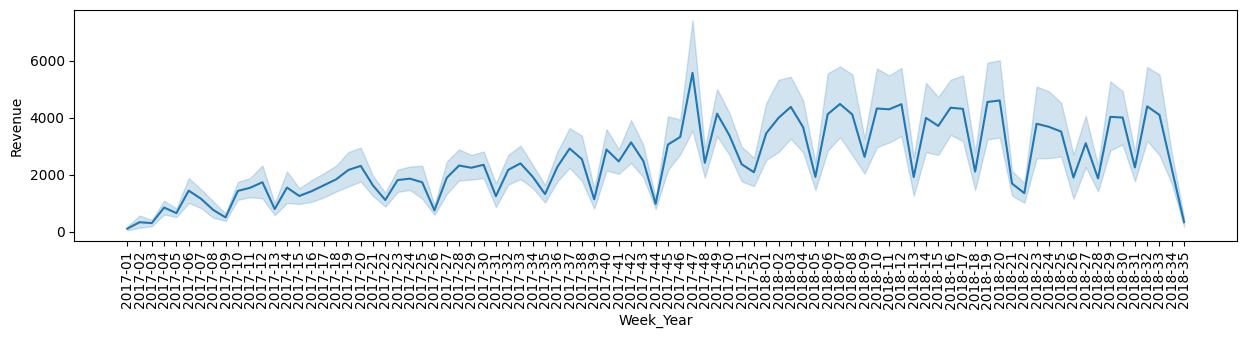

In [175]:
plt.figure(figsize=(15,3))
ax = sns.lineplot(data = Weekly_revenue_df, x='Week_Year', y='Revenue')
plt.xticks(rotation = 90)
plt.show()

# Simple Moving Average Model

Recreate the Data frame suitable for SMA

In [176]:
SMA_revenue_df = Weekly_revenue_df.groupby('week_starting_date').agg({'Revenue':'sum'})
SMA_revenue_df.reset_index('week_starting_date',inplace=True)
SMA_revenue_df.set_index('week_starting_date',inplace=True)
SMA_revenue_df

,Revenue
week_starting_date,
2017-01-02,618.96
2017-01-09,2638.89
2017-01-16,3294.22
2017-01-23,10975.48
2017-01-30,15597.90
...,...
2018-07-30,65336.40
2018-08-06,57158.12
2018-08-13,57348.50


In [177]:
# Choose the window size for the moving average
window_size = 4
# Calculate the Simple Moving Average
SMA_revenue_df['SMA'] = SMA_revenue_df['Revenue'].rolling(window=window_size).mean()
SMA_revenue_df

,Revenue,SMA
week_starting_date,,
2017-01-02,618.96,NaN
2017-01-09,2638.89,NaN
2017-01-16,3294.22,NaN
2017-01-23,10975.48,4381.8875
2017-01-30,15597.90,8126.6225
...,...,...
2018-07-30,65336.40,52539.5400
2018-08-06,57158.12,60753.5925
2018-08-13,57348.50,59982.7900


In [178]:
SMA_revenue_df.reset_index('week_starting_date',inplace=True)
SMA_revenue_df['week_starting_date'] = pd.to_datetime(SMA_revenue_df['week_starting_date'])
SMA_revenue_df.set_index('week_starting_date',inplace=True)
SMA_revenue_df

,Revenue,SMA
week_starting_date,,
2017-01-02,618.96,NaN
2017-01-09,2638.89,NaN
2017-01-16,3294.22,NaN
2017-01-23,10975.48,4381.8875
2017-01-30,15597.90,8126.6225
...,...,...
2018-07-30,65336.40,52539.5400
2018-08-06,57158.12,60753.5925
2018-08-13,57348.50,59982.7900


In [179]:
from pandas.tseries.offsets import DateOffset
future_dates=[SMA_revenue_df.index[-1]+ DateOffset(weeks=x)for x in range(0,4)]

In [180]:
future_dates = pd.date_range(start=SMA_revenue_df.index[-1] + pd.DateOffset(weeks=1), periods=4, freq='W-Mon')
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=SMA_revenue_df.columns)
future_df=pd.concat([SMA_revenue_df,future_datest_df])
future_df.tail(25)

,Revenue,SMA
2018-04-02,59883.74,60297.2225
2018-04-09,51952.84,57184.2675
2018-04-16,65250.28,56723.5825
2018-04-23,64647.98,60433.7100
2018-04-30,56852.00,59675.7750
2018-05-07,59166.41,61479.1675
2018-05-14,64464.06,61282.6125
2018-05-21,23629.23,51027.9250
2018-05-28,39135.40,46598.7750
2018-06-04,53012.39,45060.2700


In [181]:
future_df['SMA'] = future_df['Revenue'].rolling(window=window_size,min_periods=1).mean()
future_df.tail(25)

,Revenue,SMA
2018-04-02,59883.74,60297.222500
2018-04-09,51952.84,57184.267500
2018-04-16,65250.28,56723.582500
2018-04-23,64647.98,60433.710000
2018-04-30,56852.00,59675.775000
2018-05-07,59166.41,61479.167500
2018-05-14,64464.06,61282.612500
2018-05-21,23629.23,51027.925000
2018-05-28,39135.40,46598.775000
2018-06-04,53012.39,45060.270000


Forecast of Revenue with 4 week Rolling Window

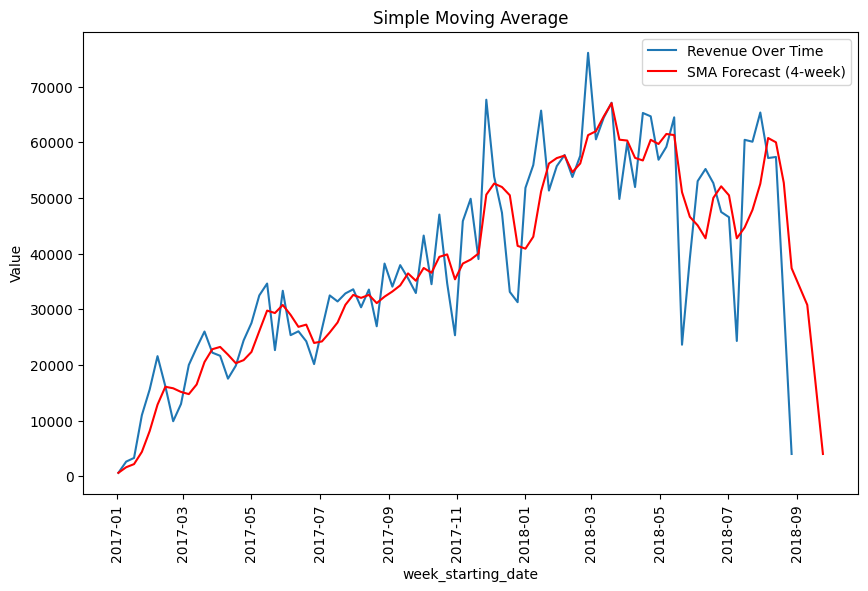

In [182]:
plt.figure(figsize=(10, 6))
plt.plot(future_df.index, future_df['Revenue'], label='Revenue Over Time')
plt.plot(future_df.index, future_df['SMA'], label=f'SMA Forecast ({window_size}-week)', color='red')
plt.title('Simple Moving Average')
plt.xlabel('week_starting_date')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Check the SMA Model Accuracy

In [183]:
SMA_revenue_df = SMA_revenue_df.dropna()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(SMA_revenue_df['Revenue'], SMA_revenue_df['SMA'])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(SMA_revenue_df['Revenue'], SMA_revenue_df['SMA'])

# Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mse)

actual_values = SMA_revenue_df['Revenue']
forecast_values = SMA_revenue_df['SMA']

# Calculate Absolute Percentage Error (APE) for each observation
ape = np.abs((actual_values - forecast_values) / actual_values)

# Handle cases where the actual values are zero to avoid division by zero
ape = np.where(actual_values == 0, 0, ape)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(ape) * 100

print('Mean Squared Error (MSE): {}'.format(mse))
print('Mean Absolute Error (MAE): {}'.format(mae))
print('Root Mean Squared Error (RMSE): {}'.format(rmse))
print('Mean Absolute Percentage Error (MAPE): {}%'.format(mape))


Mean Squared Error (MSE): 75822890.15904085
Mean Absolute Error (MAE): 6193.622232142857
Root Mean Squared Error (RMSE): 8707.634016140139
Mean Absolute Percentage Error (MAPE): 27.108197268802282%


# ARIMA Model (Autoregressive Integrated Moving Average)

In [184]:
# Import the Required Libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

## Data Formating For ARIMA

The ARIMA model only support the time of the data set and the vriable which is change with the time. Here the sales data already preprocess but they are daily records. The data set has been regrouped as weekly data, becasue then the next 24 weeks (6 month) revenue forcast can be easily moniter with sufficiant records.

 Check for Data Overview

In [185]:
ARIMA_revenue_df = Weekly_revenue_df.groupby('week_starting_date').agg({'Revenue':'sum'})
ARIMA_revenue_df.reset_index('week_starting_date',inplace=True)
ARIMA_revenue_df.set_index('week_starting_date',inplace=True)
ARIMA_revenue_df

,Revenue
week_starting_date,
2017-01-02,618.96
2017-01-09,2638.89
2017-01-16,3294.22
2017-01-23,10975.48
2017-01-30,15597.90
...,...
2018-07-30,65336.40
2018-08-06,57158.12
2018-08-13,57348.50


In [186]:
ARIMA_revenue_df.describe()

,Revenue
count,87.000000
mean,38626.192989
std,18007.775574
min,618.960000
25%,24866.600000
50%,34614.590000
75%,54503.540000
max,76053.050000


<Figure size 1500x400 with 0 Axes>

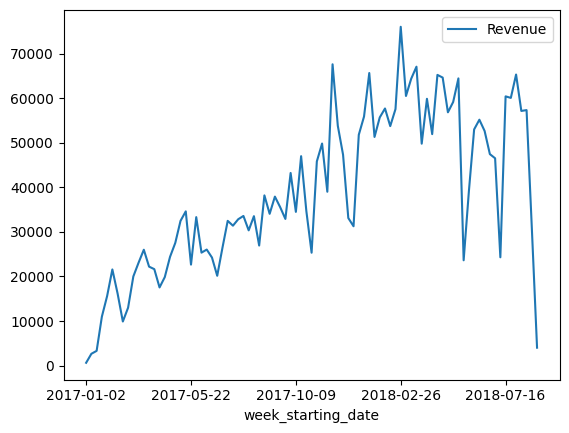

In [187]:
plt.figure(figsize=(15,4)) 
ARIMA_revenue_df.plot()
plt.show()

The above plot shows how the weekly revenue has been distributed along the time period. According to that, during 2017-10-09 and 2018-02-26, the highest revenue has been recorded.

Create a Function for adfuller_test

In [188]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(revenue):
    result=adfuller(revenue)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

Check the Stationarity of Data

In [189]:
adfuller_test(ARIMA_revenue_df['Revenue'])

ADF Test Statistic : -2.13988108208915
p-value : 0.22878341015593784
#Lags Used : 6
Number of Observations Used : 80
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


According to the Hypothesis, the data is not-stationary

In [190]:
ARIMA_revenue_df['Revenue']

week_starting_date
2017-01-02      618.96
2017-01-09     2638.89
2017-01-16     3294.22
2017-01-23    10975.48
2017-01-30    15597.90
                ...   
2018-07-30    65336.40
2018-08-06    57158.12
2018-08-13    57348.50
2018-08-20    30972.89
2018-08-27     4007.17
Name: Revenue, Length: 87, dtype: float64

Application of Differecing Technique to Acheive the Stationarity

In [191]:
ARIMA_revenue_df['Revenue First Difference'] = ARIMA_revenue_df['Revenue'] - ARIMA_revenue_df['Revenue'].shift(1)
ARIMA_revenue_df.head()

,Revenue,Revenue First Difference
week_starting_date,,
2017-01-02,618.96,NaN
2017-01-09,2638.89,2019.93
2017-01-16,3294.22,655.33
2017-01-23,10975.48,7681.26
2017-01-30,15597.90,4622.42


In [192]:
## Again test dickey fuller test by removing the first NA raw
adfuller_test(ARIMA_revenue_df['Revenue First Difference'].dropna())

ADF Test Statistic : -6.844995698797354
p-value : 1.7520024757046645e-09
#Lags Used : 5
Number of Observations Used : 80
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


The Revenue Data Distribution after Achieving Stationarity

<Axes: xlabel='week_starting_date'>

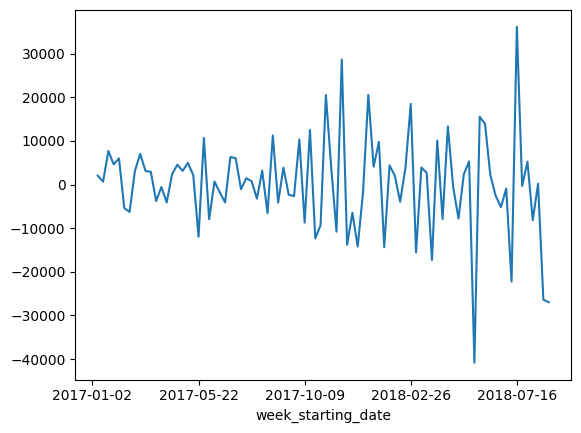

In [193]:
ARIMA_revenue_df['Revenue First Difference'].plot()

#### Auto Regressive Model

Autocorrelation plot

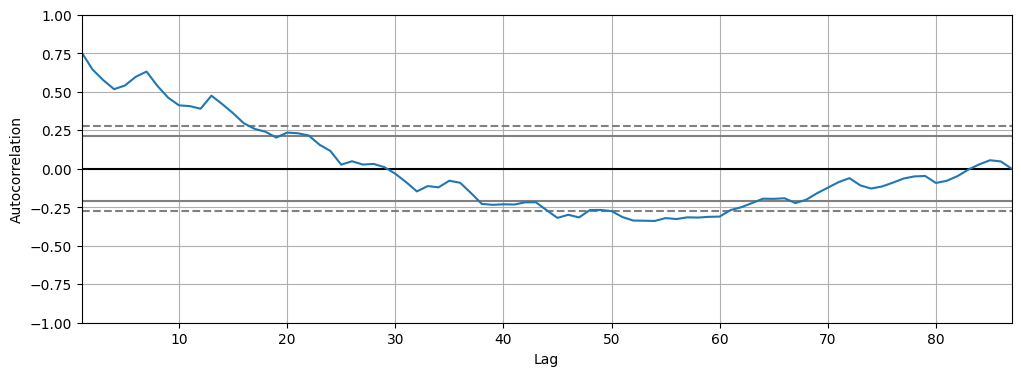

In [194]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize = (12,4))
autocorrelation_plot(ARIMA_revenue_df['Revenue'])
plt.show()

### Auto Correlation and Patial Autocorrelation

1. Identification of an AR model is often best done with the PACF.

- For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

2. Identification of an MA model is often best done with the ACF rather than the PACF.

- For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

- p,d,q 
    - p AR model lags 
    - d differencing 
    - q MA lags

In [195]:
# import required libraries
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

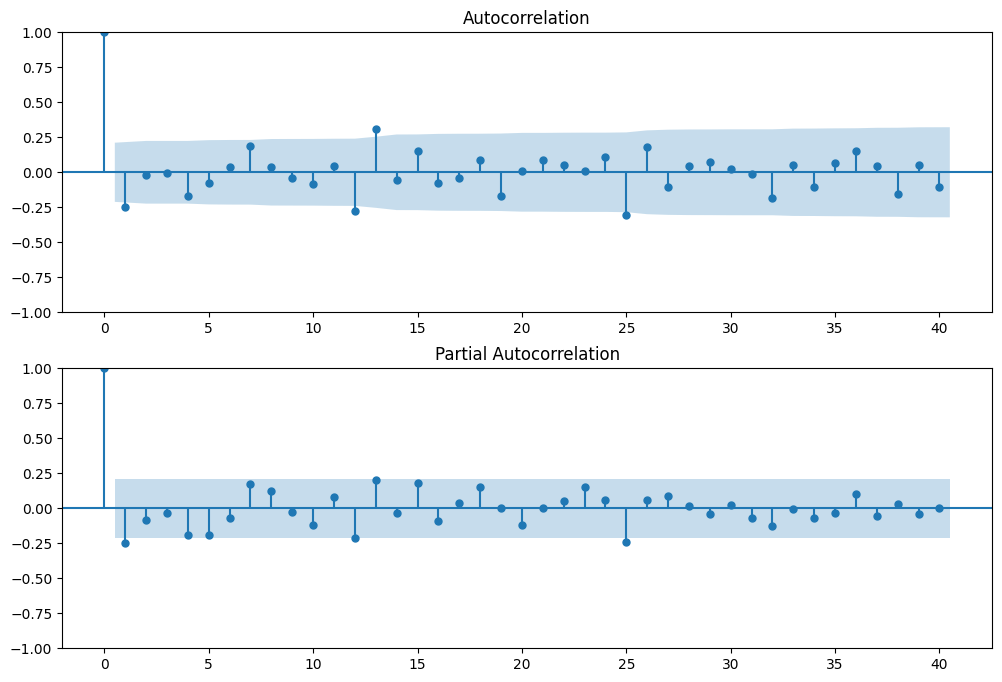

In [196]:
# use .iloc[1:] to drop the 1st value which is NA
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ARIMA_revenue_df['Revenue First Difference'].iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ARIMA_revenue_df['Revenue First Difference'].iloc[1:],lags=40,ax=ax2)

In [197]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
model=ARIMA(ARIMA_revenue_df['Revenue'],order=(2,1,1))
model_fit=model.fit()

c:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generate the model fitting Summery

In [198]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                   87
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -918.547
Date:                Sat, 06 Jan 2024   AIC                           1845.094
Time:                        17:23:40   BIC                           1854.911
Sample:                    01-02-2017   HQIC                          1849.045
                         - 08-27-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3644      0.215      1.699      0.089      -0.056       0.785
ar.L2         -0.0381      0.212     -0.180      0.857      -0.454       0.377
ma.L1         -0.7795      0.212     -3.681      0.000      -1.195      -0.364
sigma2      1.215e+08    2.4e-09   5.07e+16      0.000    1.22e+08    1.22e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                71.81
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               6.74   Skew:                            -1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.46e+31. Standard errors may be unstable.
"""

In [199]:
ARIMA_revenue_df['forecast']=model_fit.predict(start=63,end=87,dynamic=False)

In [200]:
ARIMA_revenue_df.tail()

,Revenue,Revenue First Difference,forecast
week_starting_date,,,
2018-07-30,65336.40,5248.26,54357.494212
2018-08-06,57158.12,-8178.28,58703.770810
2018-08-13,57348.50,190.38,55182.394211
2018-08-20,30972.89,-26375.61,56041.058065
2018-08-27,4007.17,-26965.72,40894.594684


Forecast Revenue line for the Past 24 Weeks

<Axes: xlabel='week_starting_date'>

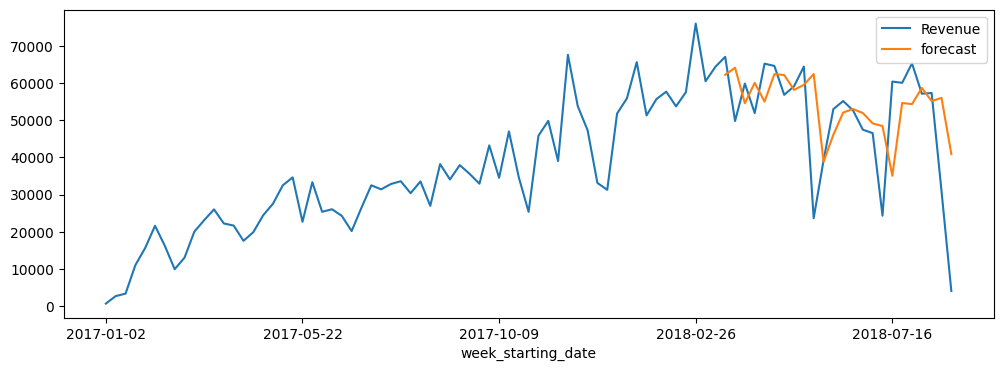

In [201]:
ARIMA_revenue_df[['Revenue','forecast']].plot(figsize=(12,4)) 

### Accuracy Test for the ARIMA

In [202]:
accaracy_test_df=ARIMA_revenue_df.dropna()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(accaracy_test_df['Revenue'],accaracy_test_df['forecast'])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(accaracy_test_df['Revenue'],accaracy_test_df['forecast'])

# Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mse)

actual_values = accaracy_test_df['Revenue']
forecast_values = accaracy_test_df['forecast']

# Calculate Absolute Percentage Error (APE) for each observation
ape = np.abs((actual_values - forecast_values) / actual_values)

# Handle cases where the actual values are zero to avoid division by zero
ape = np.where(actual_values == 0, 0, ape)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(ape) * 100

print('Mean Squared Error (MSE): {}'.format(mse))
print('Mean Absolute Error (MAE): {}'.format(mae))
print('Root Mean Squared Error (RMSE): {}'.format(rmse))
print('Mean Absolute Percentage Error (MAPE): {}%'.format(mape))

Mean Squared Error (MSE): 227217356.3299583
Mean Absolute Error (MAE): 10189.082749680832
Root Mean Squared Error (RMSE): 15073.730670605677
Mean Absolute Percentage Error (MAPE): 61.37764594560255%


#### Forecast for the next 24 Weeks

In [203]:
ARIMA_revenue_df.reset_index('week_starting_date',inplace=True)
ARIMA_revenue_df['week_starting_date'] = pd.to_datetime(ARIMA_revenue_df['week_starting_date'])
ARIMA_revenue_df.set_index('week_starting_date',inplace=True)
ARIMA_revenue_df

,Revenue,Revenue First Difference,forecast
week_starting_date,,,
2017-01-02,618.96,NaN,NaN
2017-01-09,2638.89,2019.93,NaN
2017-01-16,3294.22,655.33,NaN
2017-01-23,10975.48,7681.26,NaN
2017-01-30,15597.90,4622.42,NaN
...,...,...,...
2018-07-30,65336.40,5248.26,54357.494212
2018-08-06,57158.12,-8178.28,58703.770810
2018-08-13,57348.50,190.38,55182.394211


In [204]:
from pandas.tseries.offsets import DateOffset
future_dates=[ARIMA_revenue_df.index[-1]+ DateOffset(weeks=x)for x in range(0,24)]

In [205]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=ARIMA_revenue_df.columns)

In [206]:
future_df=pd.concat([ARIMA_revenue_df,future_datest_df])
future_df.tail(40)

,Revenue,Revenue First Difference,forecast
2018-05-07,59166.41,2314.41,58193.979988
2018-05-14,64464.06,5297.65,59549.010078
2018-05-21,23629.23,-40834.83,62475.109290
2018-05-28,39135.40,15506.17,38826.827396
2018-06-04,53012.39,13876.99,46102.568246
2018-06-11,55191.05,2178.66,52092.347836
2018-06-18,52657.07,-2533.98,53040.563357
2018-06-25,47466.92,-5190.15,51949.465741
2018-07-02,46533.01,-933.91,49166.265875
2018-07-09,24301.91,-22231.10,48443.196978


In [207]:
future_df['forecast'] = model_fit.predict(start = 63, end = 115, dynamic= False)
future_df.tail(25)

,Revenue,Revenue First Difference,forecast
2018-08-20,30972.89,-26375.61,56041.058065
2018-08-27,4007.17,-26965.72,40894.594684
2018-09-03,NaN,NaN,23939.957185
2018-09-10,NaN,NaN,32232.297994
2018-09-17,NaN,NaN,34494.658435
2018-09-24,NaN,NaN,35003.095281
2018-10-01,NaN,NaN,35102.160431
2018-10-08,NaN,NaN,35118.884590
2018-10-15,NaN,NaN,35121.203636
2018-10-22,NaN,NaN,35121.411336


Line Plot for the Forecasted Revenue

<Axes: >

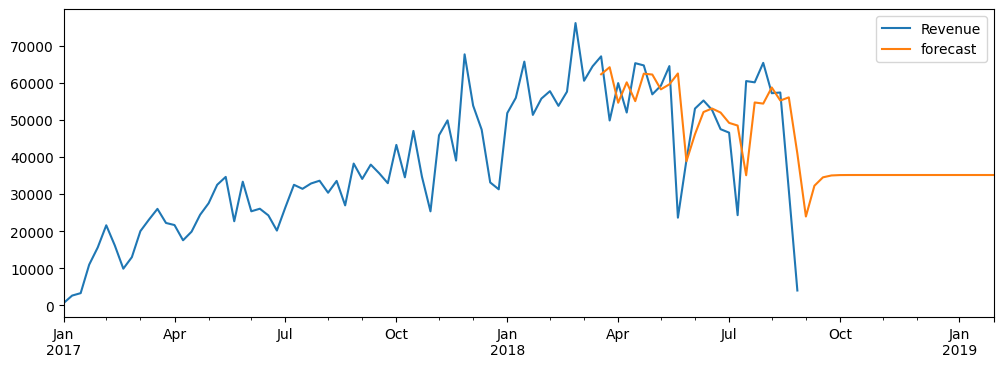

In [208]:
future_df[['Revenue', 'forecast']].plot(figsize=(12, 4)) 

# Multivariate Analysis VAR Model Approach

In [209]:
# Import the Required Libraries for the VAR Model
from statsmodels.tsa.api import VAR
from tabulate import tabulate
from statsmodels.tsa.statespace.varmax import VARMAX


In [210]:
#Weekly Sales Table with Supportive Variables
Multi_revenue_df = ecom_no_outliers.groupby(['week_starting_date']).agg({'neg':'sum','neu':'sum','pos':'sum','compound':'sum','sales_qty':'sum','review_score':'sum','price':'sum','freight_value':'sum','product_name_lenght':'mean','product_description_lenght':'mean','product_photos_qty':'mean','Revenue':'sum'})
Multi_revenue_df = Multi_revenue_df.sort_values(by=['week_starting_date'],ascending=True)
Multi_revenue_df

,neg,neu,pos,compound,sales_qty,review_score,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,Revenue
week_starting_date,,,,,,,,,,,,
2017-01-02,0.123,6.013,3.864,5.6599,10,43.0,500.19,118.77,49.300000,1110.300000,1.800000,618.96
2017-01-09,1.021,16.784,10.194,9.7588,31,103.0,4252.48,764.64,57.553571,1018.875000,2.571429,5169.90
2017-01-16,1.917,38.571,20.514,16.2880,68,234.0,5645.33,1108.03,49.418033,637.724044,1.915301,7356.05
2017-01-23,4.806,83.671,28.522,25.1328,135,425.0,12770.08,2569.89,46.538462,988.269231,2.286325,16674.03
2017-01-30,4.671,87.718,34.613,36.0468,134,492.0,14528.84,2631.37,48.405512,893.562992,2.303150,17757.31
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-30,24.778,371.519,170.708,166.9772,619,2137.0,56124.35,12198.68,49.192782,827.089789,2.230634,73042.00
2018-08-06,16.331,348.629,161.039,150.8226,574,2028.0,51812.67,12110.82,49.586792,868.291509,2.174528,68054.80
2018-08-13,12.879,317.639,144.483,150.7458,510,1927.0,44677.65,9975.74,49.716737,815.604867,2.210084,57348.50


HeatMap with Person's Correlation Values

<Axes: >

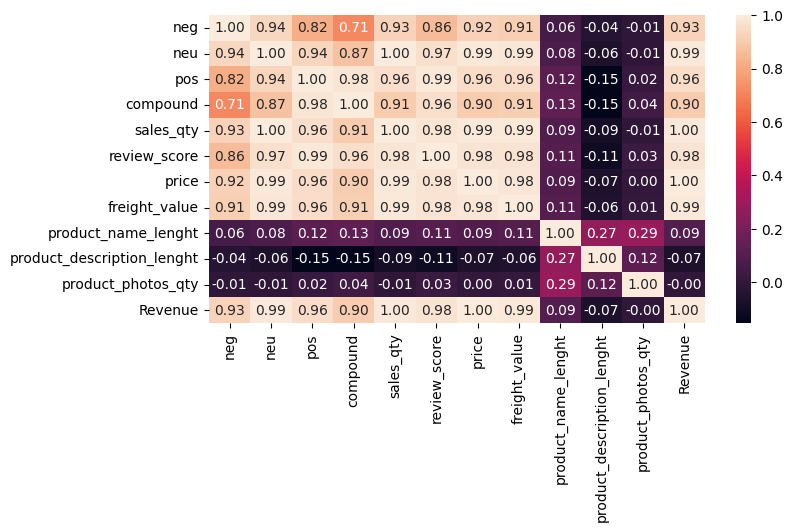

In [211]:
plt.figure(figsize=(8,4))
sns.heatmap(Multi_revenue_df.corr(),annot=True,fmt='.2f')

In [212]:
# plot all the data with time
Multi_revenue_df = Multi_revenue_df[{'neg','neu','pos','compound','sales_qty','review_score','price','freight_value','Revenue'}]
Multi_revenue_df

C:\Users\Yomal Sandaruwan\AppData\Local\Temp\ipykernel_2832\1703198298.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  Multi_revenue_df = Multi_revenue_df[{'neg','neu','pos','compound','sales_qty','review_score','price','freight_value','Revenue'}]


,neu,review_score,freight_value,pos,compound,price,neg,sales_qty,Revenue
week_starting_date,,,,,,,,,
2017-01-02,6.013,43.0,118.77,3.864,5.6599,500.19,0.123,10,618.96
2017-01-09,16.784,103.0,764.64,10.194,9.7588,4252.48,1.021,31,5169.90
2017-01-16,38.571,234.0,1108.03,20.514,16.2880,5645.33,1.917,68,7356.05
2017-01-23,83.671,425.0,2569.89,28.522,25.1328,12770.08,4.806,135,16674.03
2017-01-30,87.718,492.0,2631.37,34.613,36.0468,14528.84,4.671,134,17757.31
...,...,...,...,...,...,...,...,...,...
2018-07-30,371.519,2137.0,12198.68,170.708,166.9772,56124.35,24.778,619,73042.00
2018-08-06,348.629,2028.0,12110.82,161.039,150.8226,51812.67,16.331,574,68054.80
2018-08-13,317.639,1927.0,9975.74,144.483,150.7458,44677.65,12.879,510,57348.50


Plot the Indipendent Variables vs Time to Identify the Patterns Over the Time

C:\Users\Yomal Sandaruwan\AppData\Local\Temp\ipykernel_2832\944166002.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  Multi_revenue_df_plt = Multi_revenue_df[{'neg','neu','pos','compound','sales_qty','review_score','price','freight_value'}]


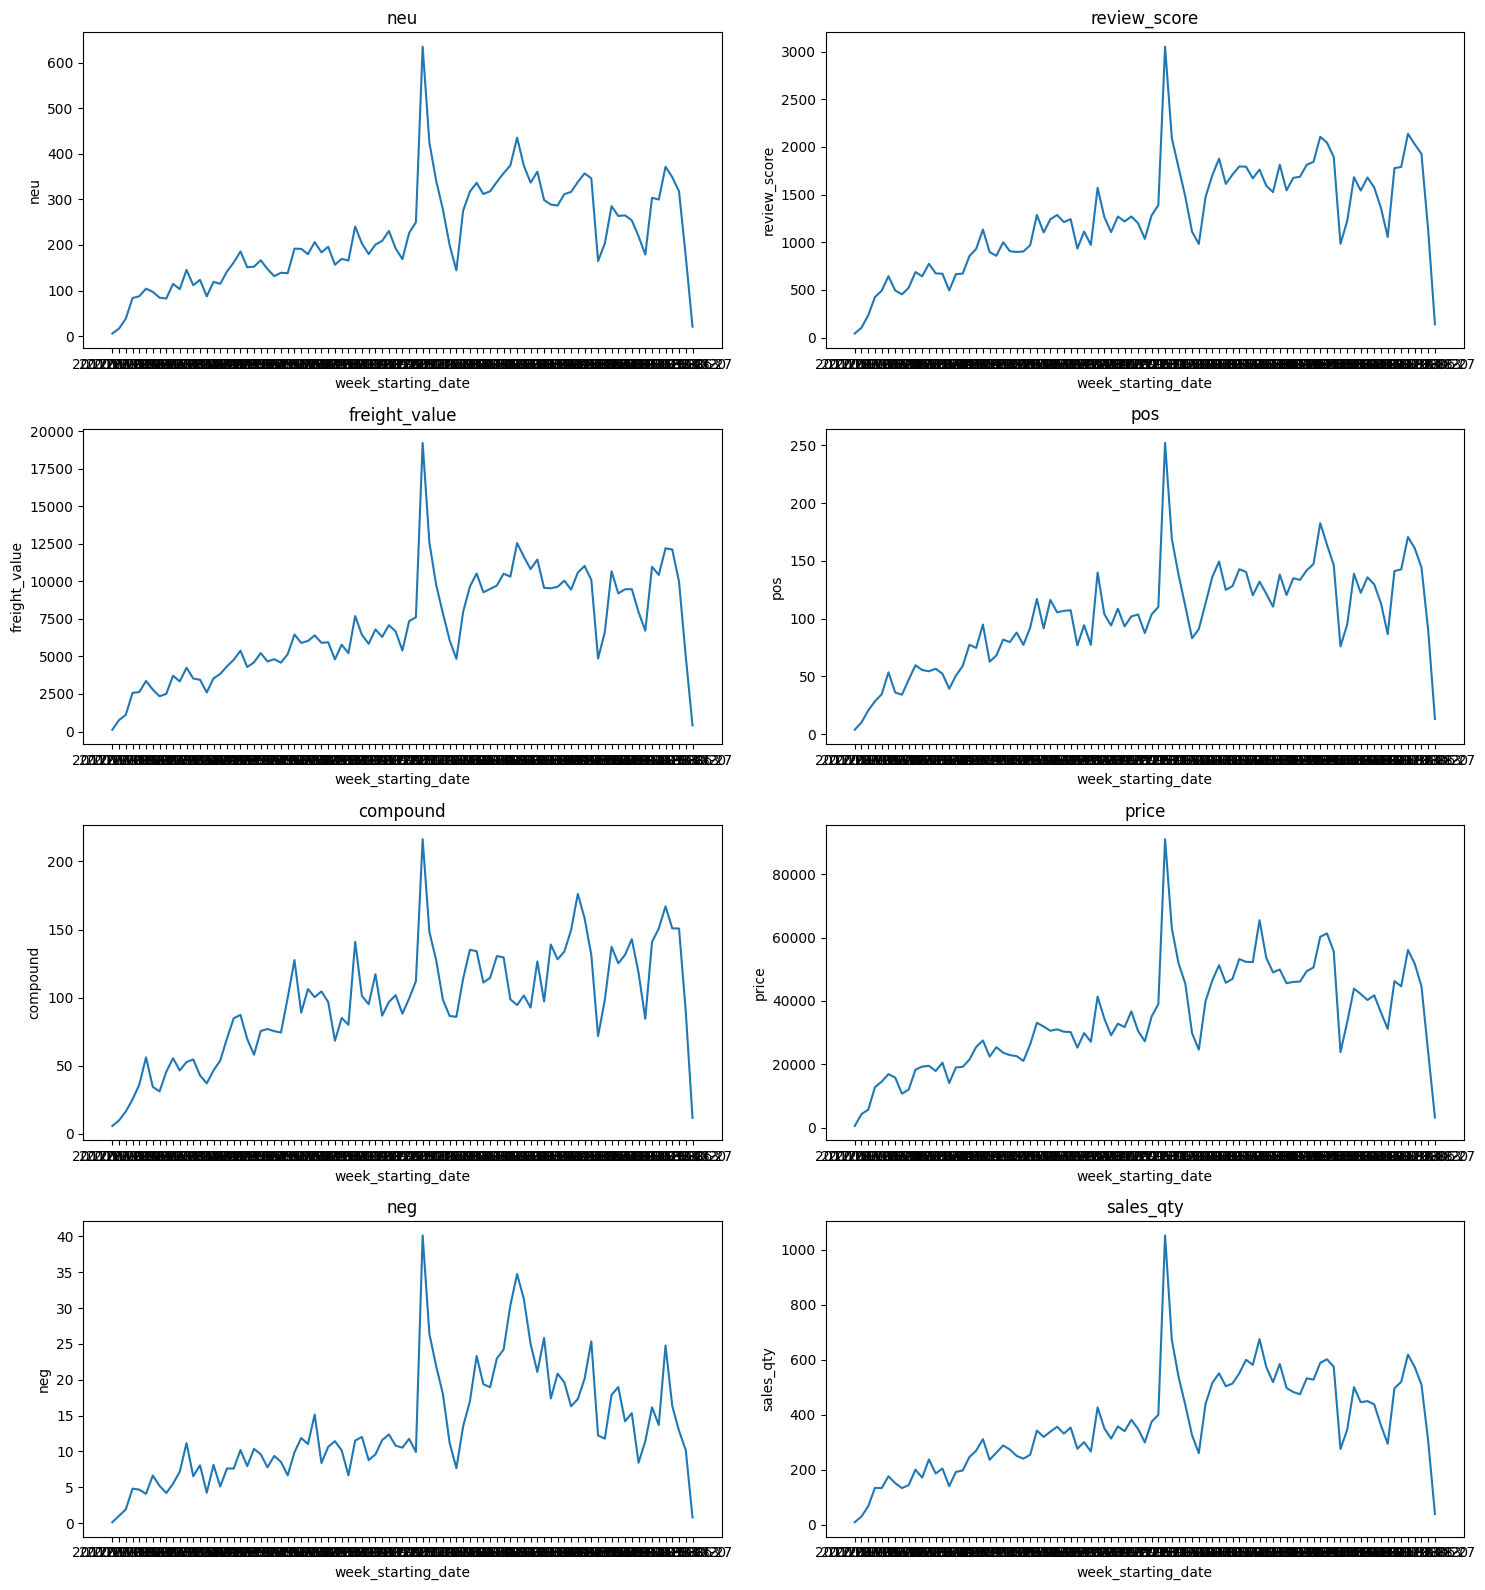

In [213]:
# Create a 4x2 subplot grid
Multi_revenue_df_plt = Multi_revenue_df[{'neg','neu','pos','compound','sales_qty','review_score','price','freight_value'}]
fig, axs = plt.subplots(4, 2, figsize=(15, 16))

for i, col in enumerate(Multi_revenue_df_plt.columns):
    # Create a line plot in the i-th subplot
    sns.lineplot(data=Multi_revenue_df_plt, x=Multi_revenue_df_plt.index, y=col, ax=axs[i // 2, i % 2])
    
    axs[i // 2, i % 2].set_title(col)  # Set the title for each subplot
    # axs[i // 2, i % 2].tick_params(axis='x', rotation=90)  # Rotate x-axis labels
    
plt.tight_layout()  # Ensures that subplots don't overlap
plt.show()


Check the Stationary of Time Series Varibles

In [214]:
# Define an empty list to store the test results
results = []

def adfuller_test(revenue):
    result = adfuller(revenue)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    row = [i]  # Store the column name as the first element
    for value, label in zip(result, labels):
        row.append(f'{label}: {value:.5f}')
    if result[1] <= 0.05:
        row.append("Result: Reject Ho (stationary)")
    else:
        row.append("Result: Weak evidence against Ho (non-stationary)")
    results.append(row)


In [215]:
for i in Multi_revenue_df.columns:
    adfuller_test(Multi_revenue_df[i])

# Print the results in a table format
headers = ["Column Name", "ADF Test Statistic", "p-value", "#Lags Used", "Num of Observations Used", "Result"]
print(tabulate(results, headers=headers, tablefmt="pretty"))


+---------------+------------------------------+------------------+---------------------+---------------------------------------+---------------------------------------------------+
|  Column Name  |      ADF Test Statistic      |     p-value      |     #Lags Used      |       Num of Observations Used        |                      Result                       |
+---------------+------------------------------+------------------+---------------------+---------------------------------------+---------------------------------------------------+
|      neu      | ADF Test Statistic: -3.10556 | p-value: 0.02614 | #Lags Used: 0.00000 | Number of Observations Used: 86.00000 |          Result: Reject Ho (stationary)           |
| review_score  | ADF Test Statistic: -2.15601 | p-value: 0.22260 | #Lags Used: 9.00000 | Number of Observations Used: 77.00000 | Result: Weak evidence against Ho (non-stationary) |
| freight_value | ADF Test Statistic: -3.09854 | p-value: 0.02666 | #Lags Used: 0.00000 | 

Application of Differencing to tAcheive the Sationarity

In [216]:
n=8
Multi_revenue_df['First_Diff_pos'] = Multi_revenue_df['pos'].diff()[n:]
Multi_revenue_df['First_Diff_compound'] = Multi_revenue_df['compound'].diff()[n:]
Multi_revenue_df['First_Diff_review_score'] = Multi_revenue_df['review_score'].diff()[n:]
Multi_revenue_df

C:\Users\Yomal Sandaruwan\AppData\Local\Temp\ipykernel_2832\2799168866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Multi_revenue_df['First_Diff_pos'] = Multi_revenue_df['pos'].diff()[n:]
C:\Users\Yomal Sandaruwan\AppData\Local\Temp\ipykernel_2832\2799168866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Multi_revenue_df['First_Diff_compound'] = Multi_revenue_df['compound'].diff()[n:]


,neu,review_score,freight_value,pos,compound,price,neg,sales_qty,Revenue,First_Diff_pos,First_Diff_compound,First_Diff_review_score
week_starting_date,,,,,,,,,,,,
2017-01-02,6.013,43.0,118.77,3.864,5.6599,500.19,0.123,10,618.96,NaN,NaN,NaN
2017-01-09,16.784,103.0,764.64,10.194,9.7588,4252.48,1.021,31,5169.90,NaN,NaN,NaN
2017-01-16,38.571,234.0,1108.03,20.514,16.2880,5645.33,1.917,68,7356.05,NaN,NaN,NaN
2017-01-23,83.671,425.0,2569.89,28.522,25.1328,12770.08,4.806,135,16674.03,NaN,NaN,NaN
2017-01-30,87.718,492.0,2631.37,34.613,36.0468,14528.84,4.671,134,17757.31,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-30,371.519,2137.0,12198.68,170.708,166.9772,56124.35,24.778,619,73042.00,27.989,16.2246,347.0
2018-08-06,348.629,2028.0,12110.82,161.039,150.8226,51812.67,16.331,574,68054.80,-9.669,-16.1546,-109.0
2018-08-13,317.639,1927.0,9975.74,144.483,150.7458,44677.65,12.879,510,57348.50,-16.556,-0.0768,-101.0


In [217]:
Multi_revenue_df = Multi_revenue_df.dropna()
Multi_revenue_df.head()

,neu,review_score,freight_value,pos,compound,price,neg,sales_qty,Revenue,First_Diff_pos,First_Diff_compound,First_Diff_review_score
week_starting_date,,,,,,,,,,,,
2017-02-27,82.624,523.0,2508.55,47.181,45.4324,12026.10,4.196,145,15539.93,12.995,14.3870,70.0
2017-03-06,114.812,687.0,3711.02,59.701,55.4417,18300.72,5.488,201,24466.43,12.520,10.0093,164.0
2017-03-13,103.251,643.0,3332.20,55.574,46.4789,19269.79,7.177,172,23089.36,-4.127,-8.9628,-44.0
2017-03-20,145.352,774.0,4245.29,54.495,52.6354,19509.87,11.154,238,25997.81,-1.079,6.1565,131.0
2017-03-27,111.814,673.0,3526.42,56.653,54.5357,17883.10,6.532,187,22203.62,2.158,1.9003,-101.0


In [218]:
Multi_revenue_df.shape

(79, 12)

In [219]:
for i in Multi_revenue_df.columns:
    adfuller_test(Multi_revenue_df[i])

# Print the results in a table format
headers = ["Column Name", "ADF Test Statistic", "p-value", "#Lags Used", "Num of Observations Used", "Result"]
print(tabulate(results, headers=headers, tablefmt="pretty"))

+-------------------------+------------------------------+------------------+---------------------+---------------------------------------+---------------------------------------------------+
|       Column Name       |      ADF Test Statistic      |     p-value      |     #Lags Used      |       Num of Observations Used        |                      Result                       |
+-------------------------+------------------------------+------------------+---------------------+---------------------------------------+---------------------------------------------------+
|           neu           | ADF Test Statistic: -3.10556 | p-value: 0.02614 | #Lags Used: 0.00000 | Number of Observations Used: 86.00000 |          Result: Reject Ho (stationary)           |
|      review_score       | ADF Test Statistic: -2.15601 | p-value: 0.22260 | #Lags Used: 9.00000 | Number of Observations Used: 77.00000 | Result: Weak evidence against Ho (non-stationary) |
|      freight_value      | ADF Test Sta

Hypothesis to find the varibles with is affecting to revenue and wise versa
- H0 : Xt does not affect to Yt
- H1 : Xt affect to Yt

In [220]:
max_lags = 4
y = Multi_revenue_df.Revenue

In [223]:
#without differencing
df_input = Multi_revenue_df[['Revenue','neu','neg','price','sales_qty','freight_value','pos', 'compound','review_score']]
df_input

,Revenue,neu,neg,price,sales_qty,freight_value,pos,compound,review_score
week_starting_date,,,,,,,,,
2017-02-27,15539.93,82.624,4.196,12026.10,145,2508.55,47.181,45.4324,523.0
2017-03-06,24466.43,114.812,5.488,18300.72,201,3711.02,59.701,55.4417,687.0
2017-03-13,23089.36,103.251,7.177,19269.79,172,3332.20,55.574,46.4789,643.0
2017-03-20,25997.81,145.352,11.154,19509.87,238,4245.29,54.495,52.6354,774.0
2017-03-27,22203.62,111.814,6.532,17883.10,187,3526.42,56.653,54.5357,673.0
...,...,...,...,...,...,...,...,...,...
2018-07-30,73042.00,371.519,24.778,56124.35,619,12198.68,170.708,166.9772,2137.0
2018-08-06,68054.80,348.629,16.331,51812.67,574,12110.82,161.039,150.8226,2028.0
2018-08-13,57348.50,317.639,12.879,44677.65,510,9975.74,144.483,150.7458,1927.0


In [224]:
df_train = df_input[:int(0.8*(len(df_input)))]
df_test = df_input[int(0.8*(len(df_input))):]

In [225]:
df_train.shape

(63, 9)

In [226]:
df_test.shape

(16, 9)

In [227]:
var_model = VAR(df_train)

c:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [228]:
sorted_order=var_model.select_order(maxlags=5)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       69.06      69.38*   9.842e+29       69.19
1       67.24       70.44   1.640e+29       68.48
2       67.67       73.74   3.063e+29       70.04
3       67.73       76.68   5.707e+29       71.22
4       67.13       78.96   1.162e+30       71.73
5      59.67*       74.38  1.430e+28*      65.40*
-------------------------------------------------


In [229]:
var_max_model = VARMAX(df_train, order=(5,0),enforce_stationarity= True)
fitted_model = var_max_model.fit(disp=False)
print(fitted_model.summary())

c:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\python\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                                    Statespace Model Results                                                                   
Dep. Variable:     ['Revenue', 'neu', 'neg', 'price', 'sales_qty', 'freight_value', 'pos', 'compound', 'review_score']   No. Observations:                   63
Model:                                                                                                          VAR(5)   Log Likelihood               -2734.053
                                                                                                           + intercept   AIC                           6386.106
Date:                                                                                                 Sat, 06 Jan 2024   BIC                           7369.805
Time:                                                                                                         17:29:51   HQIC                          6772.999
Sample:                                 

In [230]:
n_forecast = 16
predict = fitted_model.get_prediction(start=len(df_train),end=len(df_train) + n_forecast-1)
predictions=predict.predicted_mean

In [231]:
df_train.tail()

,Revenue,neu,neg,price,sales_qty,freight_value,pos,compound,review_score
week_starting_date,,,,,,,,,
2018-04-09,59192.06,286.560,20.847,46143.97,475,9630.50,133.591,128.0879,1687.0
2018-04-16,65250.28,311.464,19.638,49420.82,533,10042.48,141.894,133.7237,1813.0
2018-04-23,64647.98,316.362,16.300,50599.37,528,9444.32,147.335,149.5277,1843.0
2018-04-30,76127.91,338.009,17.300,60288.22,589,10579.60,182.689,176.1007,2106.0
2018-05-07,77458.96,356.922,20.127,61342.40,602,11019.07,163.953,158.3880,2044.0


In [232]:
predictions.columns=['Revenue','neu','neg','price','sales_qty','freight_value','First_Diff_pos','First_Diff_compound','First_Diff_review_score']
predictions=predictions.rename_axis('week_starting_date')
predictions.reset_index('week_starting_date',inplace=True)
predictions

,week_starting_date,Revenue,neu,neg,price,sales_qty,freight_value,First_Diff_pos,First_Diff_compound,First_Diff_review_score
0,2018-05-14,56737.981761,294.900911,20.536943,43271.432280,487.534753,8985.608667,120.435091,104.336095,1504.325728
1,2018-05-21,43142.902958,205.546204,10.081790,33640.593902,348.092819,6675.281797,104.820893,97.413091,1214.405784
2,2018-05-28,41562.104196,208.966717,9.714549,32516.360262,339.674461,6486.023581,94.028576,93.564017,1139.049656
3,2018-06-04,45983.521238,225.678665,12.094649,35264.445888,377.869636,7514.720804,103.750126,103.964410,1229.117365
4,2018-06-11,44528.072214,224.510405,11.864900,34119.412782,372.079834,7629.961353,105.928179,109.415300,1272.696242
5,2018-06-18,48909.875978,252.615347,12.778903,37860.236125,409.708996,7988.891675,113.060566,111.072752,1386.854097
6,2018-06-25,57710.082842,289.525345,14.762980,44748.111704,480.089964,9105.296497,137.027113,137.637874,1670.100198
7,2018-07-02,63449.289625,317.296108,19.382578,48849.593768,535.512556,9849.073115,149.014163,144.337582,1832.242391
8,2018-07-09,60260.548388,301.486896,18.159368,46284.894941,508.627831,9250.808447,140.433937,135.655769,1734.287776
9,2018-07-16,56755.590169,283.216020,17.371732,43738.387546,475.588573,8515.337473,130.484527,121.624600,1623.953350


In [233]:
df_test.reset_index('week_starting_date',inplace=True)
df_test

,week_starting_date,Revenue,neu,neg,price,sales_qty,freight_value,pos,compound,review_score
0,2018-05-14,71011.12,346.266,25.347,55605.95,575,10090.70,146.383,131.2092,1895.0
1,2018-05-21,30589.32,164.809,12.224,23863.48,276,4862.71,75.966,71.7285,983.0
2,2018-05-28,43562.30,203.117,11.781,33354.07,347,6610.53,95.103,98.2229,1225.0
3,2018-06-04,59795.09,285.212,17.878,43920.83,501,10669.61,138.913,137.2944,1682.0
4,2018-06-11,55191.05,263.615,18.980,42181.06,446,9193.61,122.403,125.1659,1542.0
5,2018-06-18,52657.07,264.947,14.200,40306.11,450,9469.51,135.850,131.4259,1679.0
6,2018-06-25,55167.23,253.980,15.341,41791.39,438,9475.65,129.677,142.8897,1574.0
7,2018-07-02,46533.01,219.233,8.424,36376.68,362,7957.22,113.346,118.2094,1359.0
8,2018-07-09,39587.73,178.965,11.425,31175.54,295,6709.68,86.613,84.4823,1055.0
9,2018-07-16,60431.71,303.612,16.154,46286.66,497,10967.09,141.234,140.8635,1777.0


In [234]:
df_test['week_starting_date'] = pd.to_datetime(df_test['week_starting_date'])

C:\Users\Yomal Sandaruwan\AppData\Local\Temp\ipykernel_2832\1525011887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['week_starting_date'] = pd.to_datetime(df_test['week_starting_date'])


In [235]:
test_vs_pred = df_test.merge(predictions, on='week_starting_date')

In [236]:
test_vs_pred.set_index('week_starting_date')

,Revenue_x,neu_x,neg_x,price_x,sales_qty_x,freight_value_x,pos,compound,review_score,Revenue_y,neu_y,neg_y,price_y,sales_qty_y,freight_value_y,First_Diff_pos,First_Diff_compound,First_Diff_review_score
week_starting_date,,,,,,,,,,,,,,,,,,
2018-05-14,71011.12,346.266,25.347,55605.95,575,10090.70,146.383,131.2092,1895.0,56737.981761,294.900911,20.536943,43271.432280,487.534753,8985.608667,120.435091,104.336095,1504.325728
2018-05-21,30589.32,164.809,12.224,23863.48,276,4862.71,75.966,71.7285,983.0,43142.902958,205.546204,10.081790,33640.593902,348.092819,6675.281797,104.820893,97.413091,1214.405784
2018-05-28,43562.30,203.117,11.781,33354.07,347,6610.53,95.103,98.2229,1225.0,41562.104196,208.966717,9.714549,32516.360262,339.674461,6486.023581,94.028576,93.564017,1139.049656
2018-06-04,59795.09,285.212,17.878,43920.83,501,10669.61,138.913,137.2944,1682.0,45983.521238,225.678665,12.094649,35264.445888,377.869636,7514.720804,103.750126,103.964410,1229.117365
2018-06-11,55191.05,263.615,18.980,42181.06,446,9193.61,122.403,125.1659,1542.0,44528.072214,224.510405,11.864900,34119.412782,372.079834,7629.961353,105.928179,109.415300,1272.696242
2018-06-18,52657.07,264.947,14.200,40306.11,450,9469.51,135.850,131.4259,1679.0,48909.875978,252.615347,12.778903,37860.236125,409.708996,7988.891675,113.060566,111.072752,1386.854097
2018-06-25,55167.23,253.980,15.341,41791.39,438,9475.65,129.677,142.8897,1574.0,57710.082842,289.525345,14.762980,44748.111704,480.089964,9105.296497,137.027113,137.637874,1670.100198
2018-07-02,46533.01,219.233,8.424,36376.68,362,7957.22,113.346,118.2094,1359.0,63449.289625,317.296108,19.382578,48849.593768,535.512556,9849.073115,149.014163,144.337582,1832.242391
2018-07-09,39587.73,178.965,11.425,31175.54,295,6709.68,86.613,84.4823,1055.0,60260.548388,301.486896,18.159368,46284.894941,508.627831,9250.808447,140.433937,135.655769,1734.287776


Text(0.5, 0, 'Time')

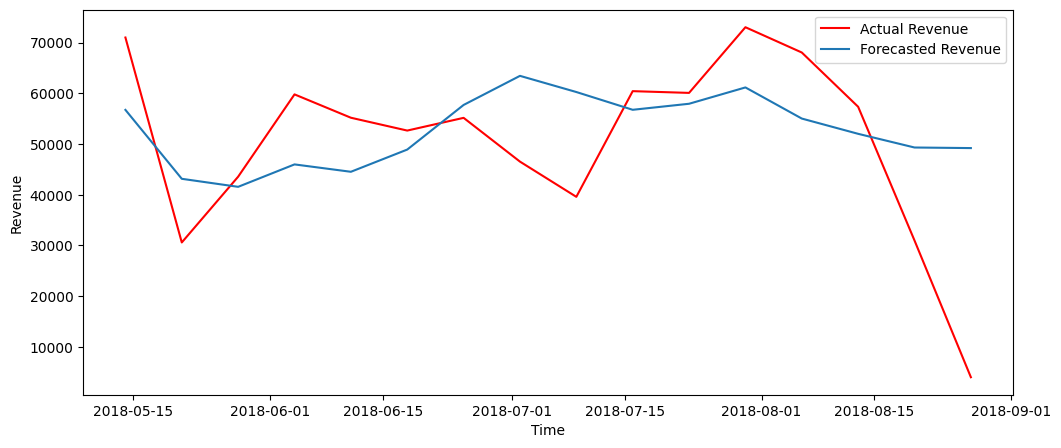

In [237]:
plt.figure(figsize=(12,5))
ax = sns.lineplot(test_vs_pred,x='week_starting_date',y='Revenue_x',color = 'red',label = 'Actual Revenue')
sns.lineplot(test_vs_pred,x='week_starting_date',y='Revenue_y', label = 'Forecasted Revenue')
plt.ylabel('Revenue')
plt.xlabel('Time')


In [238]:
test_vs_pred = test_vs_pred.dropna()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_vs_pred['Revenue_x'], test_vs_pred['Revenue_y'])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_vs_pred['Revenue_x'], test_vs_pred['Revenue_y'])

# Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mse)

actual_values = test_vs_pred['Revenue_x']
forecast_values = test_vs_pred['Revenue_y']

# Calculate Absolute Percentage Error (APE) for each observation
ape = np.abs((actual_values - forecast_values) / actual_values)

# Handle cases where the actual values are zero to avoid division by zero
ape = np.where(actual_values == 0, 0, ape)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(ape) * 100

print('Mean Squared Error (MSE): {}'.format(mse))
print('Mean Absolute Error (MAE): {}'.format(mae))
print('Root Mean Squared Error (RMSE): {}'.format(rmse))
print('Mean Absolute Percentage Error (MAPE): {}%'.format(mape))


Mean Squared Error (MSE): 258770007.73081487
Mean Absolute Error (MAE): 12298.606960342498
Root Mean Squared Error (RMSE): 16086.32984029654
Mean Absolute Percentage Error (MAPE): 90.61902768806361%


# ML Approach

In [239]:
# ML Approach with Weekly Revenue Data
## Model Development
from sklearn.preprocessing import StandardScaler #standardscaling
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA #principle component analysis

#ML Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

#Validation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse,r2_score,SCORERS #mean squre error

def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
def rmse(actual, pred):
    return np.sqrt(((actual - pred) ** 2).mean())


In [240]:
### Feature Selection and Encoding
ml_model_weekly_df = Weekly_revenue_df.groupby(['Year','Month','Month_Year','Week_Number','Week_Year','week_starting_date']).agg({'neg':'sum','neu':'sum','pos':'sum','compound':'sum','sales_qty':'sum','review_score':'sum','price':'sum','freight_value':'sum','product_name_lenght':'mean','product_description_lenght':'mean','product_photos_qty':'mean','Revenue':'sum'})
ml_model_weekly_df = ml_model_weekly_df.reset_index(drop=False)
ml_model_weekly_df = ml_model_weekly_df.sort_values(by=['week_starting_date'],ascending=True)
ml_model_weekly_df

,Year,Month,Month_Year,Week_Number,Week_Year,week_starting_date,neg,neu,pos,compound,sales_qty,review_score,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,Revenue
0,2017,1,Jan-2017,1,2017-01,2017-01-02,0.123,6.013,3.864,5.6599,10,43.0,500.19,118.77,50.111111,966.694444,2.222222,618.96
1,2017,1,Jan-2017,2,2017-02,2017-01-09,0.810,13.419,7.770,8.7280,25,83.0,1972.48,513.63,53.284722,1007.427083,3.204861,2638.89
2,2017,1,Jan-2017,3,2017-03,2017-01-16,0.778,18.885,11.338,10.5320,31,122.0,2779.07,515.15,42.642424,656.036364,2.121212,3294.22
3,2017,1,Jan-2017,4,2017-04,2017-01-23,3.166,54.653,18.180,14.5142,86,267.0,8407.23,1651.77,45.074237,836.221734,2.181044,10975.48
21,2017,2,Feb-2017,5,2017-05,2017-01-30,2.989,54.983,22.029,23.8935,83,309.0,8347.47,1581.56,48.802259,977.676709,2.480006,10163.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2018,8,Aug-2018,31,2018-31,2018-07-30,17.023,233.609,100.374,92.5857,381,1270.0,33927.04,7594.67,48.434949,865.657658,2.507617,44159.88
100,2018,8,Aug-2018,32,2018-32,2018-08-06,12.033,285.919,132.047,128.1907,466,1648.0,43624.32,10140.45,48.637186,835.186204,2.101115,57158.12
101,2018,8,Aug-2018,33,2018-33,2018-08-13,12.879,317.639,144.483,150.7458,510,1927.0,44677.65,9975.74,49.334703,808.132874,2.327628,57348.50
102,2018,8,Aug-2018,34,2018-34,2018-08-20,10.173,174.894,89.928,89.7605,305,1123.0,23733.75,4994.36,49.537873,840.343157,2.372937,30972.89


In [241]:
num_features=ml_model_weekly_df.drop(columns=['Year','Month','Week_Number','Month_Year','Revenue','Week_Year','week_starting_date'])
num_features

,neg,neu,pos,compound,sales_qty,review_score,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty
0,0.123,6.013,3.864,5.6599,10,43.0,500.19,118.77,50.111111,966.694444,2.222222
1,0.810,13.419,7.770,8.7280,25,83.0,1972.48,513.63,53.284722,1007.427083,3.204861
2,0.778,18.885,11.338,10.5320,31,122.0,2779.07,515.15,42.642424,656.036364,2.121212
3,3.166,54.653,18.180,14.5142,86,267.0,8407.23,1651.77,45.074237,836.221734,2.181044
21,2.989,54.983,22.029,23.8935,83,309.0,8347.47,1581.56,48.802259,977.676709,2.480006
...,...,...,...,...,...,...,...,...,...,...,...
99,17.023,233.609,100.374,92.5857,381,1270.0,33927.04,7594.67,48.434949,865.657658,2.507617
100,12.033,285.919,132.047,128.1907,466,1648.0,43624.32,10140.45,48.637186,835.186204,2.101115
101,12.879,317.639,144.483,150.7458,510,1927.0,44677.65,9975.74,49.334703,808.132874,2.327628
102,10.173,174.894,89.928,89.7605,305,1123.0,23733.75,4994.36,49.537873,840.343157,2.372937


Check the Relationship of Variables

<Axes: >

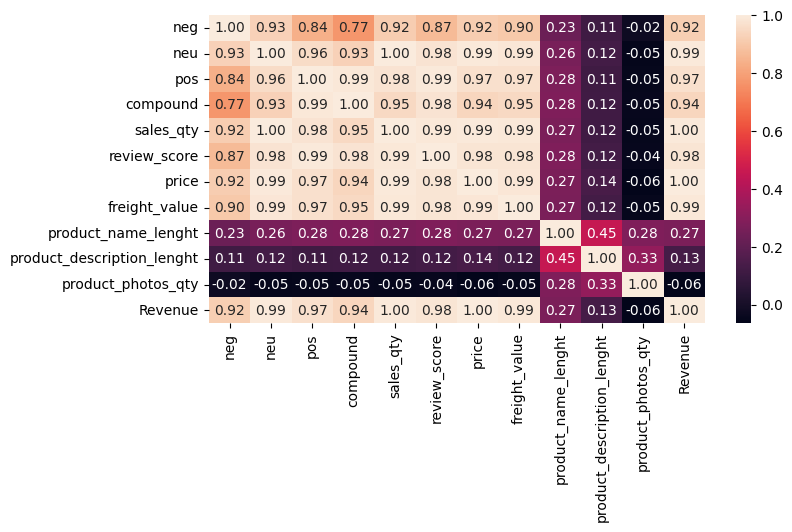

In [242]:
heat_map_df = ml_model_weekly_df.drop(columns=['Year','Month','Week_Number','Month_Year','Week_Year','week_starting_date'])
plt.figure(figsize=(8,4))
sns.heatmap(heat_map_df.corr(),annot=True,fmt='.2f')


In [243]:
heat_map_df.corr()

,neg,neu,pos,compound,sales_qty,review_score,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,Revenue
neg,1.000000,0.927330,0.835202,0.768538,0.916642,0.866103,0.915353,0.901804,0.229916,0.113030,-0.022720,0.917143
neu,0.927330,1.000000,0.957989,0.926232,0.996262,0.978254,0.992564,0.987289,0.264222,0.123876,-0.053468,0.993758
pos,0.835202,0.957989,1.000000,0.987569,0.975604,0.993378,0.969195,0.969662,0.276628,0.111378,-0.051441,0.970387
compound,0.768538,0.926232,0.987569,1.000000,0.947212,0.978955,0.939728,0.946142,0.279661,0.115761,-0.046865,0.941406
sales_qty,0.916642,0.996262,0.975604,0.947212,1.000000,0.988610,0.993189,0.989988,0.269798,0.117036,-0.051309,0.995714
review_score,0.866103,0.978254,0.993378,0.978955,0.988610,1.000000,0.981892,0.982537,0.278792,0.124129,-0.044730,0.983109
price,0.915353,0.992564,0.969195,0.939728,0.993189,0.981892,1.000000,0.986719,0.270199,0.136156,-0.064157,0.999068
freight_value,0.901804,0.987289,0.969662,0.946142,0.989988,0.982537,0.986719,1.000000,0.266734,0.124567,-0.051240,0.990722
product_name_lenght,0.229916,0.264222,0.276628,0.279661,0.269798,0.278792,0.270199,0.266734,1.000000,0.452031,0.280134,0.270130
product_description_lenght,0.113030,0.123876,0.111378,0.115761,0.117036,0.124129,0.136156,0.124567,0.452031,1.000000,0.329442,0.129272


In [244]:
y = ml_model_weekly_df.Revenue
y.reset_index()

,index,Revenue
0,0,618.96
1,1,2638.89
2,2,3294.22
3,3,10975.48
4,21,10163.73
...,...,...
99,99,44159.88
100,100,57158.12
101,101,57348.50
102,102,30972.89


In [245]:
from scipy.stats import pearsonr

# Hypothesis testing
def hypothesis_test(target_varible,dependant_varible):
    Hypothesis_test = pearsonr(target_varible,dependant_varible)
    return Hypothesis_test

n=0
test_column = num_features.columns.tolist()
for col in test_column:
    h = hypothesis_test(y,num_features[col])
    n=n+1
    print('Hypothesis',n,'Test Result:', 'Revenue vs',col, h)


Hypothesis 1 Test Result: Revenue vs neg PearsonRResult(statistic=0.917142989193963, pvalue=1.525897919781449e-42)
Hypothesis 2 Test Result: Revenue vs neu PearsonRResult(statistic=0.9937583536765717, pvalue=5.530923289098143e-99)
Hypothesis 3 Test Result: Revenue vs pos PearsonRResult(statistic=0.9703872743355888, pvalue=9.482020994942517e-65)
Hypothesis 4 Test Result: Revenue vs compound PearsonRResult(statistic=0.9414062812731754, pvalue=5.97869187909659e-50)
Hypothesis 5 Test Result: Revenue vs sales_qty PearsonRResult(statistic=0.9957142659658572, pvalue=2.7334256266187643e-107)
Hypothesis 6 Test Result: Revenue vs review_score PearsonRResult(statistic=0.9831090788734751, pvalue=4.773379939908649e-77)
Hypothesis 7 Test Result: Revenue vs price PearsonRResult(statistic=0.9990680669654985, pvalue=4.762109541518602e-141)
Hypothesis 8 Test Result: Revenue vs freight_value PearsonRResult(statistic=0.9907215075010135, pvalue=3.1004862553117002e-90)
Hypothesis 9 Test Result: Revenue vs p

In [246]:
### Identify the relationship of Target Variable and Categorical Variables - ANOVA TEST
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [247]:
H12 = ols('Revenue ~ C(Year)',data = Weekly_revenue_df).fit()
sm.stats.anova_lm(H12,typ=2) #H12th Hypothesis

,sum_sq,df,F,PR(>F)
C(Year),6.776184e+08,1.0,211.334433,9.010253e-45
Residual,4.604361e+09,1436.0,NaN,NaN


In [248]:
H13 = ols('Revenue ~ C(Month)',data = Weekly_revenue_df).fit()
sm.stats.anova_lm(H13,typ=2) #H13th Hypothesis

,sum_sq,df,F,PR(>F)
C(Month),7.891682e+07,11.0,1.966244,0.028243
Residual,5.203062e+09,1426.0,NaN,NaN


In [249]:
H14 = ols('Revenue ~ C(Week_Number)',data = Weekly_revenue_df).fit()
sm.stats.anova_lm(H14,typ=2) #H14th Hypothesis

,sum_sq,df,F,PR(>F)
C(Week_Number),8.772385e+08,51.0,5.412406,4.191582e-29
Residual,4.404741e+09,1386.0,NaN,NaN


In [250]:
### Catergorical Feature Handling (One hot Encording)
cat_features = ml_model_weekly_df[['Year', 'Month','Week_Number']]
cat_features = pd.get_dummies(cat_features)
cat_features.shape


(104, 15)

In [251]:
pca = PCA(n_components=5)
pca.fit(cat_features)
pca_transformed=pca.transform(cat_features)

#PCA Data into Data frame
pca_df=pd.DataFrame(pca_transformed)
pca_df

,0,1,2,3,4
0,-22.108683,-0.948164,0.104981,-0.154805,0.051040
1,-21.109001,-0.933330,0.103216,-0.154901,0.051040
2,-20.109319,-0.918495,0.101451,-0.154997,0.051040
3,-19.109637,-0.903661,0.099686,-0.155093,0.051040
4,-18.107923,-0.872405,0.052077,-0.159934,0.620612
...,...,...,...,...,...
99,7.874935,1.018300,-0.333968,-0.223765,0.410672
100,8.874618,1.033134,-0.335733,-0.223862,0.410672
101,9.874300,1.047968,-0.337498,-0.223958,0.410672
102,10.873982,1.062803,-0.339263,-0.224054,0.410672


In [252]:
#Concatinate the PCA Feature and Numerical Features and create new data frame as independant varible
x=pd.concat([num_features.reset_index(drop=True),pca_df.reset_index(drop=True)],axis=1)
x.shape
y.shape

(104,)

In [253]:
np.random.seed(42)
X1_train, X1_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [254]:
#Scale the varibales according to standard normal distribution
scaler=StandardScaler()
X1_train.columns = X1_train.columns.astype(str)
X1_test.columns = X1_test.columns.astype(str)

x_train =scaler.fit_transform(X1_train)
x_test =scaler.transform(X1_test)

## Linear Regression Model

In [255]:
### Linear Regression
LinearRegression_model = LinearRegression().fit(x_train,y_train)
y_pred= LinearRegression_model.predict (x_test)
y_pred

array([ 7081.34160634, 51176.46812247, 65863.85505286, 45474.10971432,
       27109.56796647,  4352.45694908, 52829.15041095, 43149.13033031,
        4401.38822399,   471.15403076, 20036.15441683, 26879.87940108,
       19319.75524923, 24112.71112543,  6618.42722548, 10131.69688238,
       64825.6838669 , 31394.00335734, 23376.35070949, 25613.83254862,
       20961.82979188])

Model Score :  0.9998710898304326
Mean Squred Error :  47923.30588333255
Root Mean Squred Error :  218.91392345698924
Mean Absolute Error :  183.94478468461253
Mean Absolute Percentage Error :  2.0698785139806155


<Axes: xlabel='Revenue', ylabel='Count'>

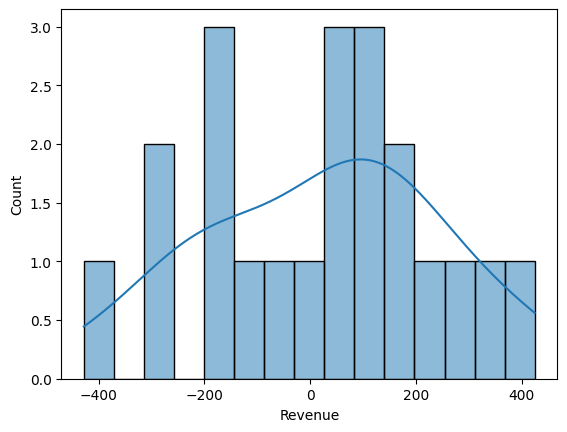

In [256]:

print('Model Score : ',r2_score(y_test, y_pred))
print('Mean Squred Error : ',mse(y_test,y_pred))
print('Root Mean Squred Error : ',rmse(y_test,y_pred)) 
print('Mean Absolute Error : ',mean_absolute_error(y_test,y_pred))
print('Mean Absolute Percentage Error : ', mape(y_test,y_pred))
sns.histplot(x = y_test - y_pred,data =ml_model_weekly_df, bins =15, kde = True)

## Decission Tree

Model Score :  0.9929841560359695
Mean Squred Error :  2608191.7155666673
Root Mean Squred Error :  1614.9896951890025
Mean Absolute Error :  1197.4490476190474
Mean Absolute Percentage Error :  21.631814213524013


<Axes: xlabel='Revenue', ylabel='Count'>

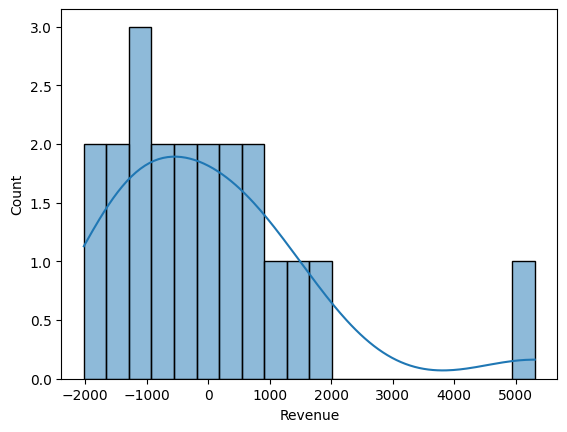

In [257]:
### Decission Tree
DecissionTree_model = DecisionTreeRegressor()
DecissionTree_model.fit(x_train,y_train)
y_pred= DecissionTree_model.predict(x_test)

print('Model Score : ',r2_score(y_test, y_pred))
print('Mean Squred Error : ',mse(y_test,y_pred))
print('Root Mean Squred Error : ',rmse(y_test,y_pred)) 
print('Mean Absolute Error : ',mean_absolute_error(y_test,y_pred))
print('Mean Absolute Percentage Error : ', mape(y_test,y_pred))
sns.histplot(x = y_test - y_pred,data =ml_model_weekly_df, bins =20, kde = True)

## Random Forest Regression

Model Score :  0.9968123184873887
Mean Squred Error :  1185044.1024178
Root Mean Squred Error :  1088.5973095767783
Mean Absolute Error :  865.6230047619011
Mean Absolute Percentage Error :  24.466533566549437


<Axes: xlabel='Revenue', ylabel='Count'>

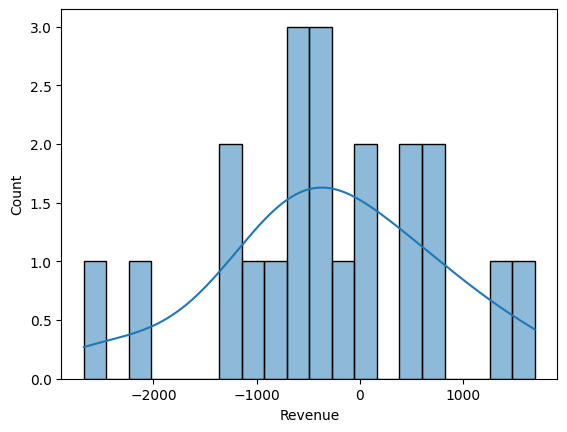

In [258]:
### Random Forest
RandomForest_model = RandomForestRegressor()
RandomForest_model.fit(x_train,y_train)
y_pred= RandomForest_model.predict(x_test)

print('Model Score : ',r2_score(y_test, y_pred))
print('Mean Squred Error : ',mse(y_test,y_pred))
print('Root Mean Squred Error : ',rmse(y_test,y_pred)) 
print('Mean Absolute Error : ',mean_absolute_error(y_test,y_pred))
print('Mean Absolute Percentage Error : ', mape(y_test,y_pred))
sns.histplot(x = y_test - y_pred,data =ml_model_weekly_df, bins =20, kde = True)

## Gradiant Boost

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


Model Score :  0.996753109791802
Mean Squred Error :  1207055.3714982357
Root Mean Squred Error :  1098.660717190815
Mean Absolute Error :  961.4799130394347
Mean Absolute Percentage Error :  21.949929414335386


<Axes: xlabel='Revenue', ylabel='Count'>

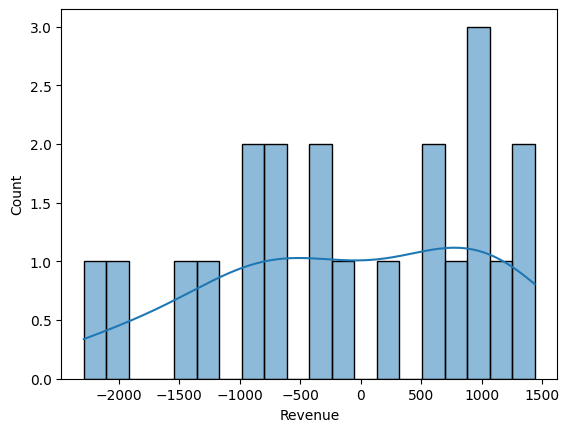

In [259]:
### Gradiant Boost
XGBOOST_model = XGBRegressor()
print(XGBOOST_model)
XGBOOST_model.fit(x_train,y_train)
y_pred= XGBOOST_model.predict(x_test)

print('Model Score : ',r2_score(y_test, y_pred))
print('Mean Squred Error : ',mse(y_test,y_pred))
print('Root Mean Squred Error : ',rmse(y_test,y_pred)) 
print('Mean Absolute Error : ',mean_absolute_error(y_test,y_pred))
print('Mean Absolute Percentage Error : ', mape(y_test,y_pred))
sns.histplot(x = y_test - y_pred,data =ml_model_weekly_df, bins =20, kde = True)

## ADA Boost

In [260]:
### ADA Boost
DessicisionTree_estimator = DecisionTreeRegressor( max_depth = 1, random_state=0)
ADABOOST_model = AdaBoostRegressor(base_estimator = DessicisionTree_estimator, n_estimators = 50,learning_rate =1)
print(ADABOOST_model)
ADABOOST_model.fit(x_train,y_train)
y_pred= ADABOOST_model.predict(x_test)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1,
                                                       random_state=0),
                  learning_rate=1)


c:\python\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model Score :  0.7311743376632793
Mean Squred Error :  99937921.80001076
Root Mean Squred Error :  9996.895608138097
Mean Absolute Error :  7537.551123992455
Mean Absolute Percentage Error :  230.31928105783254


<Axes: xlabel='Revenue', ylabel='Count'>

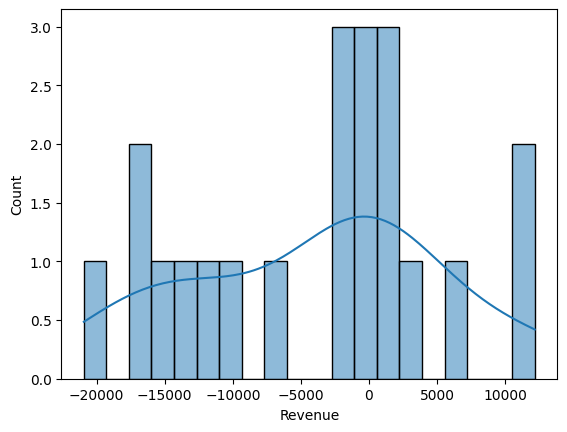

In [261]:
print('Model Score : ',r2_score(y_test, y_pred))
print('Mean Squred Error : ',mse(y_test,y_pred))
print('Root Mean Squred Error : ',rmse(y_test,y_pred)) 
print('Mean Absolute Error : ',mean_absolute_error(y_test,y_pred))
print('Mean Absolute Percentage Error : ', mape(y_test,y_pred))
sns.histplot(x = y_test - y_pred,data =ml_model_weekly_df, bins =20, kde = True)